# VIXM Predictor using an adaBoost Model

In [1]:
# Import appropriate modules

import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import datetime
import numpy as np
import yfinance as yf
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from vix_functions import garch_fit_and_predict, correlation_filter, retrieve_yahoo_close, retrieve_yahoo_volume

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# CONTROL PANEL

90.0

In [404]:
# Key parameters of the model

# Min return to set up a positive signal
threshold= 0.00 

# Split of data
training_period_months = 104

# Adaboost parameters
adaboost_estimators = 9
learning_rate_adaboost = 0.9
max_depth=1


# Inclusion of the first 4 components lag1
#n: number of components to include
number_of_pca_lag_component_to_include = 4
num_pca_components = 40


# Definition of demo mode or development mode
demo_mode = False
parameter_tuning_mode = True
run_multiple_tuning_iterations = True

#Dates
start_date='2011-02-01'
today=datetime.today().date()
end_date=(today+DateOffset(days=-1)).date()
start_date_volatilities=(pd.to_datetime(start_date)+DateOffset(days=-364)).date()

print(f"start date: {start_date}, end date: {end_date}, start date volatilities: {start_date_volatilities}")

start date: 2011-02-01, end date: 2021-11-19, start date volatilities: 2010-02-02


# Generation of the Features Matrix X

### X1: close prices
#### 40 units: 
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [405]:
# Ticker List: VIX must be in first position
# ticker_list_ORIGINAL= ["^VIX", "spy", 'XLF', 'XLE',
#               'EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
#               '^TNX', 'ZB=F', 'ZF=F', 'NQ=F','NKD=F',                                       
#               'LQD',
#               'AAPL', 'AMZN', 'GE','MU','MSFT', 'BMY', 'FDX', 'GS','PLD','NVDA',   
#               "tlt", "ief", 
#               "FXI", "EZU", "EEM", "EFA", 'FEZ', "^GDAXI", '^FTSE','^HSI','^FCHI',              #'^GSPC',
#               "gld", "slv", "CL=F"]

ticker_list= ["VIXM","^VIX", "spy", 
               'GBPUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
              '^TNX', 'ZF=F', 'NQ=F','NKD=F',                                       
              'LQD',
              'AAPL', 'AMZN','MU','MSFT', 'BMY', 'PLD', 
              "FXI", 'FEZ', '^FTSE','^FCHI','^GSPC',
              "gld", "slv", 
              "ES=F","QM=F", "BIO=F"
             ]



    
# Some of the less familiar tickers are listed below
# CAC 40 (^FCHI)
# Yen Denominated TOPIX Futures,D (TPY=F)
# FTSE 100 (^FTSE)
# SPDR EURO STOXX 50 ETF (FEZ)
# DAX PERFORMANCE-INDEX (^GDAXI)
# S&P500 Index (^GSPC)
# HANG SENG INDEX (^HSI)
# 13 Week Treasury Bill (^IRX) --eliminate
# Nikkei/USD Futures,Dec-2021 (NKD=F)
# iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD)
# Nasdaq 100 Dec 21 (NQ=F)
# NVIDIA Corporation (NVDA)
# Euro spot  'EURUSD'
# American Funds U.S. Government Securities Fund Class C (UGSCX) - 2001
# Micron Technology, Inc. (MU)
# Microsoft Corporation (MSFT)
# Bristol-Myers Squibb Company (BMY)
# FEDEX CORP (FDX)
# The Goldman Sachs Group, Inc. (GS)
# Prologis, Inc. (PLD)
# Treasury Yield 10 Years (^TNX) -- 1985
# Energy Select Sector SPDR Fund (XLE)
# Financial Select Sector SPDR Fund (XLF)
# U.S. Treasury Bond Futures,Dec- (ZB=F) - 2000
# Five-Year US Treasury Note Futu (ZF=F) - 2000
# E-Mini S&P500 (ES=F)
# E-Mini oil (QM=F)
# E-MinI Nasdaq (BIO=F)
print(f"Current number of tickers: {len(ticker_list)}")


Current number of tickers: 28


In [406]:
# X1: Upload of data using API
def retrieve_close(close_prices_dict, ticker_list):
    """
    This function retrieves close prices from Yahoo Finance
    
    Arg:
    close_prices_dict: empty dictionary to be filled with the close prices
    ticker_list: a list of tickers of the yahoo close prices to be retrieve
    
    Return:
    A dictionary with close prices
    """
    
    
    for ticker in ticker_list:
        close_price = retrieve_yahoo_close(ticker, start_date=start_date, end_date=end_date)
        close_prices_dict[ticker] = close_price
    return close_prices_dict


if demo_mode == True:
    close_prices_df = pd.read_csv("adaboost_close_prices.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    close_prices_dict = {}
    close_prices_dict = retrieve_close(close_prices_dict, ticker_list)
    close_prices_df_raw= pd.DataFrame(close_prices_dict)
    close_prices_df_raw.to_csv("adaboost_close_prices.csv", index=True)
print("Completed retrieve of close prices")

Processing Close VIXM
Processing Close ^VIX
Processing Close spy
Processing Close GBPUSD=X
Processing Close BRLUSD=X
Processing Close DX-Y.NYB
Processing Close USDJPY=X
Processing Close ^TNX
Processing Close ZF=F
Processing Close NQ=F
Processing Close NKD=F
Processing Close LQD
Processing Close AAPL
Processing Close AMZN
Processing Close MU
Processing Close MSFT
Processing Close BMY
Processing Close PLD
Processing Close FXI
Processing Close FEZ
Processing Close ^FTSE
Processing Close ^FCHI
Processing Close ^GSPC
Processing Close gld
Processing Close slv
Processing Close ES=F
Processing Close QM=F
Processing Close BIO=F
Completed retrieve of close prices


In [407]:
#close_prices_df_raw.loc['2011-07-1':'2011-07-06']
close_prices_df

VIXM       ^VIX         spy  GBPUSD=X  BRLUSD=X   DX-Y.NYB  \
Date                                                                           
2011-02-01  274.839996  17.629999  106.105354  1.603001  0.599880  77.070000   
2011-02-02  274.239990  17.299999  105.902443  1.613606  0.600528  77.160004   
2011-02-03  272.600006  16.690001  106.137817  1.620483  0.601431  77.750000   
2011-02-04  269.239990  15.930000  106.438087  1.613450  0.599377  78.040001   
2011-02-07  265.839996  16.280001  107.103600  1.609969  0.615688  78.029999   
...                ...        ...         ...       ...       ...        ...   
2021-11-15   30.209999  16.490000  467.429993  1.341706  0.183231  95.410004   
2021-11-16   30.330000  16.370001  469.279999  1.340842  0.183274  95.919998   
2021-11-17   30.770000  17.110001  468.140015  1.342462  0.181745  95.830002   
2021-11-18   30.860001  17.590000  469.730011  1.349164  0.180874  95.540001   
2021-11-19         NaN        NaN         NaN  1.349965  0.179973  96.070000   

              USDJPY=X   ^TNX        ZF=F      NQ=F  ...        FXI  \
Date                                                 ...              
2011-02-01   82.070000  3.443  118.070312   2322.50  ...  32.982857   
2011-02-02   81.390999  3.489  117.687500   2319.75  ...  32.944363   
2011-02-03   81.492996  3.541  117.398438   2321.75  ...  32.859680   
2011-02-04   81.650002  3.652  116.851562   2337.50  ...  33.005962   
2011-02-07   82.220001  3.644  116.882812   2345.00  ...  32.698002   
...                ...    ...         ...       ...  ...        ...   
2021-11-15  113.981003  1.623  121.406250  16187.75  ...  41.110001   
2021-11-16  114.132004  1.634  121.343750  16300.75  ...  41.630001   
2021-11-17  114.903999  1.604  121.476562  16311.50  ...  41.160000   
2021-11-18  114.190002  1.589  121.546875  16481.25  ...  40.270000   
2021-11-19  114.281998  1.536  121.625000  16575.00  ...        NaN   

                  FEZ        ^FTSE        ^FCHI        ^GSPC         gld  \
Date                                                                       
2011-02-01  29.282949  5957.799805  4072.620117  1307.589966  130.800003   
2011-02-02  29.125755  6000.100098  4066.530029  1304.030029  130.449997   
2011-02-03  28.825634  5983.299805  4036.590088  1307.099976  132.199997   
2011-02-04  28.789907  5997.399902  4047.209961  1310.869995  131.660004   
2011-02-07  28.932816  6051.000000  4090.800049  1319.050049  131.679993   
...               ...          ...          ...          ...         ...   
2021-11-15  48.279999  7351.899902  7128.629883  4682.799805  174.179993   
2021-11-16  48.279999  7327.000000  7152.600098  4700.899902  172.919998   
2021-11-17  48.290001  7291.200195  7156.850098  4688.669922  174.500000   
2021-11-18  48.419998  7256.000000  7141.979980  4704.540039  173.940002   
2021-11-19        NaN  7223.600098  7112.290039          NaN         NaN   

                  slv     ES=F       QM=F        BIO=F  
Date                                                    
2011-02-01  27.870001  1302.75  90.775002   982.599976  
2011-02-02  27.690001  1300.00  90.849998   983.000000  
2011-02-03  28.290001  1303.25  90.550003   977.200012  
2011-02-04  28.400000  1307.25  89.025002   979.700012  
2011-02-07  28.660000  1315.75  87.474998   980.700012  
...               ...      ...        ...          ...  
2021-11-15  23.240000  4679.00  80.875000  4821.500000  
2021-11-16  22.959999  4696.00  80.750000  4826.000000  
2021-11-17  23.170000  4686.25  78.349998  4822.500000  
2021-11-18  22.959999  4701.50  79.010002  4806.000000  
2021-11-19        NaN  4694.50  75.949997  4831.000000  

[2819 rows x 28 columns]

In [408]:
# X1 Fill of missing values
close_prices_df=close_prices_df_raw.ffill(axis='rows')
close_prices_df=close_prices_df_raw.bfill(axis='rows')

# Apply correlation filter to keep just series with some minimum level of correlation of 0.2
close_prices_component_df = correlation_filter(close_prices_df, min_corr=0.20, key_column='VIXM', eliminate_first_column=True)

# First columns is not given back, so we take opportunity to rename them
X1=close_prices_component_df
vixm=close_prices_df['VIXM']
vixm_ret=close_prices_df['VIXM'].pct_change()
# #VIXM=pd.DataFrame([vixm, vixm_ret]).T      
# #VIXM.columns=['VIXM','VIXM_ret'

vixm=pd.DataFrame([vixm]).T
vixm.columns=['VIXM']

vixm_ret=pd.DataFrame([vixm_ret]).T
vixm_ret.columns=['VIXM_ret']



X1_no_suffix=pd.concat([vixm,close_prices_component_df], axis=1)

X1=X1_no_suffix.add_suffix("_close")

print("Completed inclusion of close prices")
X1.head()

Completed inclusion of close prices


VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-01  274.839996   17.629999  106.105362        1.603001   
2011-02-02  274.239990   17.299999  105.902443        1.613606   
2011-02-03  272.600006   16.690001  106.137787        1.620483   
2011-02-04  269.239990   15.930000  106.438080        1.613450   
2011-02-07  265.839996   16.280001  107.103577        1.609969   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  \
Date                                                                     
2011-02-01        0.599880       77.070000       82.070000  118.070312   
2011-02-02        0.600528       77.160004       81.390999  117.687500   
2011-02-03        0.601431       77.750000       81.492996  117.398438   
2011-02-04        0.599377       78.040001       81.650002  116.851562   
2011-02-07        0.615688       78.029999       82.220001  116.882812   

            NQ=F_close  NKD=F_close  ...  FXI_close  FEZ_close  ^FTSE_close  \
Date                                 ...                                      
2011-02-01     2322.50      10335.0  ...  32.982857  29.282949  5957.799805   
2011-02-02     2319.75      10460.0  ...  32.944359  29.125748  6000.100098   
2011-02-03     2321.75      10510.0  ...  32.859680  28.825628  5983.299805   
2011-02-04     2337.50      10640.0  ...  33.005959  28.789902  5997.399902   
2011-02-07     2345.00      10665.0  ...  32.697994  28.932825  6051.000000   

            ^FCHI_close  ^GSPC_close   gld_close  slv_close  ES=F_close  \
Date                                                                      
2011-02-01  4072.620117  1307.589966  130.800003  27.870001     1302.75   
2011-02-02  4066.530029  1304.030029  130.449997  27.690001     1300.00   
2011-02-03  4036.590088  1307.099976  132.199997  28.290001     1303.25   
2011-02-04  4047.209961  1310.869995  131.660004  28.400000     1307.25   
2011-02-07  4090.800049  1319.050049  131.679993  28.660000     1315.75   

            QM=F_close  BIO=F_close  
Date                                 
2011-02-01   90.775002   982.599976  
2011-02-02   90.849998   983.000000  
2011-02-03   90.550003   977.200012  
2011-02-04   89.025002   979.700012  
2011-02-07   87.474998   980.700012  

[5 rows x 27 columns]

In [409]:
#close_prices_df
#X1

In [410]:
# Presentation graphs of the SPY and the VIX

presentation_graph=pd.concat([X1['spy_close'], 2.5*X1['VIXM_close']],axis=1).hvplot(
        title='VIXM and S&P (Scale adjusted)',
        width=1000
)
presentation_graph

graph1=X1['spy_close'].hvplot(
                title= "SPY: iShares S&P 500 ETF Close Price",
                ylabel= 'Close Price [$]'
) 

graph2=X1['VIXM_close'].hvplot(
                color ='red',
                title ='VIXM close price',
                ylabel= '[%]'

)
display(graph1)
graph2 



:Curve   [Date]   (spy_close)

:Curve   [Date]   (VIXM_close)

### X2: returns

In [411]:
# Inclusion of security returns X2
# Include returns that are correlated more than 0.20 with the VIXM return

security_returns_df= close_prices_df.pct_change()
security_returns_component_df = correlation_filter(
                                        security_returns_df, 
                                        min_corr=0.20, 
                                        key_column='VIXM', 
                                        eliminate_first_column=False
)

X2_no_suffix=security_returns_component_df

X2=X2_no_suffix.add_suffix("_returns")

print("Completed inclusion of returns")

X2

Completed inclusion of returns


VIXM_returns  ^VIX_returns  spy_returns  ^TNX_returns  \
Date                                                                
2011-02-01           NaN           NaN          NaN           NaN   
2011-02-02     -0.002183     -0.018718    -0.001912      0.013360   
2011-02-03     -0.005980     -0.035260     0.002222      0.014904   
2011-02-04     -0.012326     -0.045536     0.002829      0.031347   
2011-02-07     -0.012628      0.021971     0.006252     -0.002191   
...                  ...           ...          ...           ...   
2021-11-15      0.009018      0.012277     0.000342      0.025917   
2021-11-16      0.003972     -0.007277     0.003958      0.006778   
2021-11-17      0.014507      0.045205    -0.002429     -0.018360   
2021-11-18      0.002925      0.028054     0.003396     -0.009352   
2021-11-19      0.000000      0.000000     0.000000     -0.033354   

            ZF=F_returns  NQ=F_returns  NKD=F_returns  AAPL_returns  \
Date                                                                  
2011-02-01           NaN           NaN            NaN           NaN   
2011-02-02     -0.003242     -0.001184       0.012095     -0.002058   
2011-02-03     -0.002456      0.000862       0.004780     -0.002556   
2011-02-04     -0.004658      0.006784       0.012369      0.008910   
2011-02-07      0.000267      0.003209       0.002350      0.015526   
...                  ...           ...            ...           ...   
2021-11-15     -0.000643     -0.000309       0.000336      0.000067   
2021-11-16     -0.000515      0.006981       0.003531      0.006667   
2021-11-17      0.001095      0.000659      -0.009048      0.016490   
2021-11-18      0.000579      0.010407       0.001860      0.028536   
2021-11-19      0.000643      0.005688       0.000169      0.000000   

            AMZN_returns  MU_returns  MSFT_returns  BMY_returns  PLD_returns  \
Date                                                                           
2011-02-01           NaN         NaN           NaN          NaN          NaN   
2011-02-02      0.008251    0.007400     -0.001786     0.000396    -0.008128   
2011-02-03      0.001037    0.000918     -0.010380     0.008702     0.004249   
2011-02-04      0.012780    0.013761      0.004340     0.007843     0.000302   
2011-02-07      0.002842    0.021719      0.015484     0.005058     0.012084   
...                  ...         ...           ...          ...          ...   
2021-11-15      0.005824   -0.006727     -0.001930     0.003197     0.009341   
2021-11-16     -0.001405    0.000391      0.010236    -0.008722    -0.004860   
2021-11-17      0.002344   -0.017576      0.000679     0.005753     0.006088   
2021-11-18      0.041437    0.020673      0.006340    -0.006729     0.001330   
2021-11-19      0.000000    0.000000      0.000000     0.000000     0.000000   

            FXI_returns  FEZ_returns  ^FTSE_returns  ^FCHI_returns  \
Date                                                                 
2011-02-01          NaN          NaN            NaN            NaN   
2011-02-02    -0.001167    -0.005368       0.007100      -0.001495   
2011-02-03    -0.002570    -0.010304      -0.002800      -0.007363   
2011-02-04     0.004452    -0.001239       0.002357       0.002631   
2011-02-07    -0.009331     0.004964       0.008937       0.010770   
...                 ...          ...            ...            ...   
2021-11-15    -0.007484    -0.005151       0.000544       0.005250   
2021-11-16     0.012649     0.000000      -0.003387       0.003363   
2021-11-17    -0.011290     0.000207      -0.004886       0.000594   
2021-11-18    -0.021623     0.002692      -0.004828      -0.002078   
2021-11-19     0.000000     0.000000      -0.004465      -0.004157   

            ^GSPC_returns  ES=F_returns  BIO=F_returns  
Date                                                    
2011-02-01            NaN           NaN            NaN  
2011-02-02      -0.002723     -0.002111       0.000407  
2011-02-03

In [412]:
#security_returns_component_df.head()
X2

VIXM_returns  ^VIX_returns  spy_returns  ^TNX_returns  \
Date                                                                
2011-02-01           NaN           NaN          NaN           NaN   
2011-02-02     -0.002183     -0.018718    -0.001912      0.013360   
2011-02-03     -0.005980     -0.035260     0.002222      0.014904   
2011-02-04     -0.012326     -0.045536     0.002829      0.031347   
2011-02-07     -0.012628      0.021971     0.006252     -0.002191   
...                  ...           ...          ...           ...   
2021-11-15      0.009018      0.012277     0.000342      0.025917   
2021-11-16      0.003972     -0.007277     0.003958      0.006778   
2021-11-17      0.014507      0.045205    -0.002429     -0.018360   
2021-11-18      0.002925      0.028054     0.003396     -0.009352   
2021-11-19      0.000000      0.000000     0.000000     -0.033354   

            ZF=F_returns  NQ=F_returns  NKD=F_returns  AAPL_returns  \
Date                                                                  
2011-02-01           NaN           NaN            NaN           NaN   
2011-02-02     -0.003242     -0.001184       0.012095     -0.002058   
2011-02-03     -0.002456      0.000862       0.004780     -0.002556   
2011-02-04     -0.004658      0.006784       0.012369      0.008910   
2011-02-07      0.000267      0.003209       0.002350      0.015526   
...                  ...           ...            ...           ...   
2021-11-15     -0.000643     -0.000309       0.000336      0.000067   
2021-11-16     -0.000515      0.006981       0.003531      0.006667   
2021-11-17      0.001095      0.000659      -0.009048      0.016490   
2021-11-18      0.000579      0.010407       0.001860      0.028536   
2021-11-19      0.000643      0.005688       0.000169      0.000000   

            AMZN_returns  MU_returns  MSFT_returns  BMY_returns  PLD_returns  \
Date                                                                           
2011-02-01           NaN         NaN           NaN          NaN          NaN   
2011-02-02      0.008251    0.007400     -0.001786     0.000396    -0.008128   
2011-02-03      0.001037    0.000918     -0.010380     0.008702     0.004249   
2011-02-04      0.012780    0.013761      0.004340     0.007843     0.000302   
2011-02-07      0.002842    0.021719      0.015484     0.005058     0.012084   
...                  ...         ...           ...          ...          ...   
2021-11-15      0.005824   -0.006727     -0.001930     0.003197     0.009341   
2021-11-16     -0.001405    0.000391      0.010236    -0.008722    -0.004860   
2021-11-17      0.002344   -0.017576      0.000679     0.005753     0.006088   
2021-11-18      0.041437    0.020673      0.006340    -0.006729     0.001330   
2021-11-19      0.000000    0.000000      0.000000     0.000000     0.000000   

            FXI_returns  FEZ_returns  ^FTSE_returns  ^FCHI_returns  \
Date                                                                 
2011-02-01          NaN          NaN            NaN            NaN   
2011-02-02    -0.001167    -0.005368       0.007100      -0.001495   
2011-02-03    -0.002570    -0.010304      -0.002800      -0.007363   
2011-02-04     0.004452    -0.001239       0.002357       0.002631   
2011-02-07    -0.009331     0.004964       0.008937       0.010770   
...                 ...          ...            ...            ...   
2021-11-15    -0.007484    -0.005151       0.000544       0.005250   
2021-11-16     0.012649     0.000000      -0.003387       0.003363   
2021-11-17    -0.011290     0.000207      -0.004886       0.000594   
2021-11-18    -0.021623     0.002692      -0.004828      -0.002078   
2021-11-19     0.000000     0.000000      -0.004465      -0.004157   

            ^GSPC_returns  ES=F_returns  BIO=F_returns  
Date                                                    
2011-02-01            NaN           NaN            NaN  
2011-02-02      -0.002723     -0.002111       0.000407  
2011-02-03

### X3: volume

In [413]:
# inclusion of security volume X3
volume_list = ticker_list[0:len(ticker_list)]

def retrieve_volume(volume_dict, volume_list):
    """
    This function retrieve volume trades from a list of tickers
    
    Args:
    volume_dict: an initial dictionary to populate
    volume_list: the list of tickers for which to retrieve the volume
    
    
    Return:
    The original dictionary filled with the volume of the list of tickers
    """
    for ticker in volume_list:        
        volume = retrieve_yahoo_volume(ticker, start_date=start_date, end_date=end_date)
        volume_dict[ticker] = volume
    return volume_dict

if demo_mode == True:
    volume_df = pd.read_csv("adaboost_volume.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    volume_dict = {}
    volume_dict = retrieve_volume(volume_dict, volume_list)
    volume_df= pd.DataFrame(volume_dict)
    volume_df.to_csv("adaboost_volume.csv", index=True)
print("Completed retrieve of volume")

volume_df_with_vixm=pd.concat([vixm_ret, volume_df], axis=1)
#print(volume_df_with_vixm.corr())

volume_component_df = correlation_filter(volume_df_with_vixm, min_corr=0.14, key_column='VIXM_ret', eliminate_first_column=True )
X3_no_suffix=volume_component_df

X3=X3_no_suffix.add_suffix("_volume")

Processing Volume VIXM
Processing Volume ^VIX
Processing Volume spy
Processing Volume GBPUSD=X
Processing Volume BRLUSD=X
Processing Volume DX-Y.NYB
Processing Volume USDJPY=X
Processing Volume ^TNX
Processing Volume ZF=F
Processing Volume NQ=F
Processing Volume NKD=F
Processing Volume LQD
Processing Volume AAPL
Processing Volume AMZN
Processing Volume MU
Processing Volume MSFT
Processing Volume BMY
Processing Volume PLD
Processing Volume FXI
Processing Volume FEZ
Processing Volume ^FTSE
Processing Volume ^FCHI
Processing Volume ^GSPC
Processing Volume gld
Processing Volume slv
Processing Volume ES=F
Processing Volume QM=F
Processing Volume BIO=F
Completed retrieve of volume


In [414]:
#volume_component_df
#X3
#volume_df_with_vixm

### X4: GARCH Models
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution 

In [415]:
# Inclusion of GARCH series X4
garch_series_df=pd.DataFrame()

not_to_include=[]#['BIO=F']


for ticker in ticker_list:
    
        if ticker in not_to_include:
            continue
    
        if demo_mode == True:
            print_series = False
        else:
            print_series = True
        garch_series_df[ticker]=garch_fit_and_predict(security_returns_df[ticker], ticker, horizon=1, p=1, q=1, o=1, print_series_name=print_series)
            
        
X4_no_suffix=garch_series_df
X4=X4_no_suffix.add_suffix("_garch")

if demo_mode == False:
    X4

print('GARCH Process fit and predictions completed')


Processing series: VIXM.....
Processing series: ^VIX.....
Processing series: spy.....
Processing series: GBPUSD=X.....
Processing series: BRLUSD=X.....
Processing series: DX-Y.NYB.....
Processing series: USDJPY=X.....
Processing series: ^TNX.....
Processing series: ZF=F.....
Processing series: NQ=F.....
Processing series: NKD=F.....
Processing series: LQD.....
Processing series: AAPL.....
Processing series: AMZN.....
Processing series: MU.....
Processing series: MSFT.....
Processing series: BMY.....
Processing series: PLD.....
Processing series: FXI.....
Processing series: FEZ.....
Processing series: ^FTSE.....
Processing series: ^FCHI.....
Processing series: ^GSPC.....
Processing series: gld.....
Processing series: slv.....
Processing series: ES=F.....
Processing series: QM=F.....
Processing series: BIO=F.....
GARCH Process fit and predictions completed


In [416]:
garch_series_df
#X4

VIXM      ^VIX       spy  GBPUSD=X  BRLUSD=X  DX-Y.NYB  \
Date                                                                     
2011-02-02  1.673954  0.669996  0.696941  0.456503  1.332509  0.401752   
2011-02-03  1.572365  0.640387  0.650886  0.453905  1.300432  0.422079   
2011-02-04  1.507946  0.617928  0.610983  0.456707  1.271882  0.420950   
2011-02-07  1.456081  0.608288  0.576588  0.452111  1.283778  0.413737   
2011-02-08  1.418213  0.593836  0.547102  0.446142  1.253981  0.406751   
...              ...       ...       ...       ...       ...       ...   
2021-11-15  1.360817  0.610775  0.566116  0.545086  0.973989  0.360086   
2021-11-16  1.323005  0.595692  0.538157  0.535777  0.952402  0.369010   
2021-11-17  1.467165  0.625216  0.541159  0.526885  0.958136  0.363383   
2021-11-18  1.403436  0.619709  0.516911  0.523063  0.945119  0.361553   
2021-11-19  1.794291  0.362856  0.247042  0.264501  0.871153  0.138028   

            USDJPY=X      ^TNX      ZF=F      NQ=F  ...       FXI       FEZ  \
Date                                                ...                       
2011-02-02  0.605392  1.614614  2.836787  0.844522  ...  1.158450  1.244630   
2011-02-03  0.582316  1.595158  2.807357  0.800864  ...  1.136747  1.267496   
2011-02-04  0.561737  1.609540  2.910451  0.762261  ...  1.114463  1.200158   
2011-02-07  0.569629  1.581149  2.828275  0.728256  ...  1.133940  1.139902   
2011-02-08  0.548002  1.574840  2.925950  0.698413  ...  1.110846  1.095035   
...              ...       ...       ...       ...  ...       ...       ...   
2021-11-15  0.395704  2.926204  2.147063  0.871859  ...  1.480528  0.847895   
2021-11-16  0.384971  2.867084  2.091471  0.825104  ...  1.445939  0.813617   
2021-11-17  0.412532  2.849884  2.053340  0.783677  ...  1.451099  0.782463   
2021-11-18  0.440246  2.802002  2.003360  0.747105  ...  1.572569  0.755648   
2021-11-19  0.181382  8.321402  3.827628  0.511141  ...  2.320654  0.532834   

               ^FTSE     ^FCHI     ^GSPC       gld       slv      ES=F  \
Date                                                                     
2011-02-02  0.722572  0.833914  0.710511  0.709447  2.050215  0.716975   
2011-02-03  0.705016  0.876686  0.662822  0.761946  2.066338  0.667864   
2011-02-04  0.678156  0.835428  0.621491  0.753017  2.032505  0.625581   
2011-02-07  0.653664  0.797476  0.585857  0.740431  2.007110  0.591543   
2011-02-08  0.631379  0.762624  0.555300  0.770387  2.100578  0.560925   
...              ...       ...       ...       ...       ...       ...   
2021-11-15  0.535285  0.503513  0.574536  0.833107  1.530554  0.562497   
2021-11-16  0.545314  0.496043  0.545629  0.828843  1.520592  0.535661   
2021-11-17  0.575674  0.489396  0.549535  0.839531  1.509700  0.532252   
2021-11-18  0.600132  0.496234  0.524341  0.826380  1.494371  0.509878   
2021-11-19  0.378739  0.284726  0.253454  0.658351  2.165507  0.252655   

                QM=F     BIO=F  
Date                            
2011-02-02  0.208812  0.681045  
2011-02-03  0.195160  0.677413  
2011-02-04  0.198510  0.613157  
2011-02-07  0.202231  0.549307  
2011-02-08  0.190842  0.492235  
...              ...       ...  
2021-11-15  0.205357  1.085251  
2021-11-16  0.191659  0.963536  
2021-11-17  0.225920  0.856566  
2021-11-18  0.210908  0.781457  
2021-11-19  0.070448  0.530407  

[2818 rows x 28 columns]

### X5: Return squared


In [417]:
# Inclusion of return squares in X5

returns_squared_df= security_returns_df**2
returns_squared_and_vixm_ret_df=pd.concat([vixm_ret,returns_squared_df], axis=1)
returns_squared_and_vixm_ret_df
returns_squared_component_df = correlation_filter(returns_squared_and_vixm_ret_df, min_corr=0.20, key_column='VIXM', eliminate_first_column=True)

X5_no_suffix_df=returns_squared_component_df
X5=X5_no_suffix_df.add_suffix("_return_squared")

if demo_mode == False:
    X5
print("Completed inclusion of return squared")
X5.head()

Completed inclusion of return squared


VIXM_return_squared  ^VIX_return_squared  spy_return_squared  \
Date                                                                       
2011-02-01                  NaN                  NaN                 NaN   
2011-02-02             0.000005             0.000350            0.000004   
2011-02-03             0.000036             0.001243            0.000005   
2011-02-04             0.000152             0.002074            0.000008   
2011-02-07             0.000159             0.000483            0.000039   

            DX-Y.NYB_return_squared  ^TNX_return_squared  ZF=F_return_squared  \
Date                                                                            
2011-02-01                      NaN                  NaN                  NaN   
2011-02-02             1.363806e-06             0.000179         1.051213e-05   
2011-02-03             5.846745e-05             0.000222         6.032854e-06   
2011-02-04             1.391227e-05             0.000983         2.169959e-05   
2011-02-07             1.642673e-08             0.000005         7.152057e-08   

            NQ=F_return_squared  NKD=F_return_squared  LQD_return_squared  \
Date                                                                        
2011-02-01                  NaN                   NaN                 NaN   
2011-02-02         1.402019e-06              0.000146            0.000004   
2011-02-03         7.433231e-07              0.000023            0.000006   
2011-02-04         4.601826e-05              0.000153            0.000009   
2011-02-07         1.029483e-05              0.000006            0.000001   

            AAPL_return_squared  ...  BMY_return_squared  PLD_return_squared  \
Date                             ...                                           
2011-02-01                  NaN  ...                 NaN                 NaN   
2011-02-02             0.000004  ...        1.569127e-07        6.606296e-05   
2011-02-03             0.000007  ...        7.572440e-05        1.805336e-05   
2011-02-04             0.000079  ...        6.152011e-05        9.147703e-08   
2011-02-07             0.000241  ...        2.558800e-05        1.460319e-04   

            FXI_return_squared  FEZ_return_squared  ^FTSE_return_squared  \
Date                                                                       
2011-02-01                 NaN                 NaN                   NaN   
2011-02-02            0.000001            0.000029              0.000050   
2011-02-03            0.000007            0.000106              0.000008   
2011-02-04            0.000020            0.000002              0.000006   
2011-02-07            0.000087            0.000025              0.000080   

            ^FCHI_return_squared  ^GSPC_return_squared  slv_return_squared  \
Date                                                                         
2011-02-01                   NaN                   NaN                 NaN   
2011-02-02              0.000002              0.000007            0.000042   
2011-02-03              0.000054              0.000006            0.000470   
2011-02-04              0.000007              0.000008            0.000015   
2011-02-07              0.000116              0.000039            0.000084   

            ES=F_return_squared  BIO=F_return_squared  
Date                                                   
2011-02-01                  NaN                   NaN  
2011-02-02             0.000004          1.657370e-07  
2011-02-03             0.000006          3.481345e-05  
2011-02-04             0.000009          6.545052e-06  
2011-02-07             0.000042          1.041871e-06  

[5 rows x 22 columns]

In [418]:
#returns_squared_df
#X5

### X6: Google Trends

In [419]:
# # Upload of Google Tremds -- X6
# keywords=['banking', "consumer", "depression", "gdp", "inflation",
#           'unemployment', 'liquidity','cci', 'vix_word']
# google_trends_df=pd.DataFrame()

# for keyword in keywords:
#     file_path=f"./Resources/Google_trends/{keyword}.csv"
#     if demo_mode == False:
#         print(file_path)
#     trend=pd.read_csv(Path(file_path),
#                       index_col= 'Daily', 
#                       parse_dates= True,
#                       infer_datetime_format=True
#                      )
#     #print(trend)
#     google_trends_df=pd.concat([google_trends_df, trend], axis=1)
#     #print(google_trends_df)

# if demo_mode == False:
#     google_trends_df
# print('Google Trends load completed')

In [420]:
# # Working on preparing Google-trends data

# # Unifying google dates with VIX
# minimum_date=vix.index.min()
# maximum_date=vix.index.max()

# google_trends_df=google_trends_df.loc[minimum_date:maximum_date,:]
# #print(google_trends_df.iloc[0,:])

# vix_google_trends_df=pd.concat([vix, google_trends_df], axis=1)
# vix_google_trends_df.isna().sum()

# #print(vix_google_trends_df.head())

# #vix_google_trends_df=vix_google_trends_df.fillna(0)
# #vix_google_trends_df
# #vix_google_trends_df.loc[vix_google_trends_df['^VIX'].isna(),['^VIX','Banking: (United States)']]

# # We will drop Saturday Sunday, but we would like to average Fri-Sat-Sun and reset the value of Friday
# vix_google_trends_df=vix_google_trends_df.dropna()
# google_trends_df=vix_google_trends_df.iloc[:,1:]
# #google_trends_df.isna().sum()

In [421]:
# # Filtering by correlation X6

# google_trends_component_df = correlation_filter(
#                                 vix_google_trends_df, 
#                                 min_corr=0.05, 
#                                 key_column='^VIX', 
#                                 eliminate_first_column=True)

# X6=google_trends_component_df

# # We will interpolate so we can fill the missing data only on Google Trends
# pro_interpolation_of_X6=pd.concat([vix, X6], axis=1)
# pro_interpolation_of_X6=pro_interpolation_of_X6.interpolate(method="polynomial", order=2, axis=0)
# pro_interpolation_of_X6
# X6_no_suffix_df = pro_interpolation_of_X6.iloc[:,1:]
# X6 = X6_no_suffix_df.add_suffix("_google_trends")

# if demo_mode == False:
#     X6.shape
# print('Google Trends process inclusion completed')

### X7: Economic and Financial Series

In [422]:
# #Economic Series
# # Upload of csv files -- X7
# keywords=['JobClaimsWeeklySeries', 'vix_put_call_ratio']
# economic_series_df=pd.DataFrame()

# for keyword in keywords:
#     file_path=f"./Resources/Economic_and_financial_Series/{keyword}.csv"
#     if demo_mode == False:
#         print(file_path)
#     new_series=pd.read_csv(Path(file_path),
#                       index_col= 'DATE', 
#                       parse_dates= True,
#                       infer_datetime_format=True
#                      )
#     new_series=new_series.iloc[:,0]
#     if keyword=='JobClaimsWeeklySeries':
#         new_series=new_series.shift(-1, freq='D')
#     if demo_mode == False:
#         print(new_series)
#     # Adjustment due to weekend data. We are going to assign data on the weekends to Friday, since are going to be 
#     # consider for the the prediction of Monday
#     economic_series_df=pd.concat([economic_series_df, new_series], axis=1)
#     #print(economic_series_df.tail())

# economic_series_df
# economic_series_change_df = economic_series_df.pct_change().add_suffix('_change')

# if demo_mode == False:
#     economic_series_df.loc[:,:].tail(20)

In [423]:
# # Preparation of economic variables

# # Changes of columns that are on a weekend - concat with vix to add week days
# vix_economic= pd.concat([vix,economic_series_df,economic_series_change_df ],axis=1)
# vix_economic['VIX Put/Call Ratio']= vix_economic['VIX Put/Call Ratio'].fillna(0)

# # Applying interpolation to appropiate columns. Levels: interpolation, changes: zeros
# vix_economic.loc[:,economic_series_df.columns]=vix_economic.loc[:,economic_series_df.columns].interpolate(method="polynomial", order=2, axis=0)
# vix_economic.loc[:,economic_series_change_df.columns]=vix_economic.loc[:,economic_series_change_df.columns].fillna(0)

# #print(vix_economic)

# #Filtering for available dates
# economic_series_ready_df = vix_economic.loc[minimum_date:maximum_date,:]
# economic_series_ready_df = economic_series_ready_df.iloc[:,1:]

# X7_no_suffix_df=economic_series_ready_df
# X7=X7_no_suffix_df.add_suffix("_macroeconomics")

# print("Completed inclusion of economic variables")

### X8: volatility of the SPY in several rolling windows

In [424]:
# SPY volatility on varios tracks X8

#if demo_mode == True:
#    close_price_spy_df = pd.read_csv("adaboost_spy_data.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
    
# Retrieve yahoo close prices for spy, so to be able to calculate rolling volatilities
#else:
close_price_spy_df = retrieve_yahoo_close('spy', start_date= start_date_volatilities, end_date=end_date)  #MATCH DATE ABOVE
close_price_spy_df.to_csv("adaboost_spy_data.csv", index=True)
    
# Calculate returns
spy_returns_df=close_price_spy_df.pct_change()

#Initialize dataframe for volatility
spy_volatility=pd.DataFrame()

# Define rolling windows to create
windows_for_lag=[10,20,30,60,90,120,180,200,260]

# Loop to create the volatilities
for window_size in windows_for_lag:
    column_name=f"{window_size}_spy_rolling_volatility"
    spy_volatility[column_name] = spy_returns_df.rolling(window=window_size).std()

# Concatenate to vix to uniform index
X8=pd.concat([vixm, spy_volatility], axis=1)

# Define min and max values for the window
X8=X8.loc[start_date:end_date,:]        ## CORRECT MAXIMUM DATE
    
# Fill missing data
X8=X8.ffill()
X8=X8.iloc[:,1:]

# Setting for demo
if demo_mode == False:
    X8.shape
print("Inclusion of rolling volatilities completed")
X8.tail()

Processing Close spy
Inclusion of rolling volatilities completed


10_spy_rolling_volatility  20_spy_rolling_volatility  \
Date                                                               
2021-11-15                   0.004663                   0.004320   
2021-11-16                   0.004658                   0.004147   
2021-11-17                   0.004520                   0.004237   
2021-11-18                   0.004409                   0.004250   
2021-11-19                   0.004409                   0.004250   

            30_spy_rolling_volatility  60_spy_rolling_volatility  \
Date                                                               
2021-11-15                   0.005334                   0.007071   
2021-11-16                   0.005148                   0.007007   
2021-11-17                   0.005223                   0.007019   
2021-11-18                   0.005096                   0.007025   
2021-11-19                   0.005096                   0.007025   

            90_spy_rolling_volatility  120_spy_rolling_volatility  \
Date                                                                
2021-11-15                   0.006787                    0.006465   
2021-11-16                   0.006789                    0.006471   
2021-11-17                   0.006783                    0.006478   
2021-11-18                   0.006788                    0.006479   
2021-11-19                   0.006788                    0.006479   

            180_spy_rolling_volatility  200_spy_rolling_volatility  \
Date                                                                 
2021-11-15                    0.007137                    0.007422   
2021-11-16                    0.007058                    0.007368   
2021-11-17                    0.006989                    0.007372   
2021-11-18                    0.006872                    0.007338   
2021-11-19                    0.006872                    0.007338   

            260_spy_rolling_volatility  
Date                                    
2021-11-15                    0.007814  
2021-11-16                    0.007705  
2021-11-17                    0.007625  
2021-11-18                    0.007625  
2021-11-19                    0.007625

In [425]:
#spy_volatility
X8

10_spy_rolling_volatility  20_spy_rolling_volatility  \
Date                                                               
2011-02-01                   0.009219                   0.006961   
2011-02-02                   0.008504                   0.006989   
2011-02-03                   0.008434                   0.006935   
2011-02-04                   0.008437                   0.006901   
2011-02-07                   0.008465                   0.006930   
...                               ...                        ...   
2021-11-15                   0.004663                   0.004320   
2021-11-16                   0.004658                   0.004147   
2021-11-17                   0.004520                   0.004237   
2021-11-18                   0.004409                   0.004250   
2021-11-19                   0.004409                   0.004250   

            30_spy_rolling_volatility  60_spy_rolling_volatility  \
Date                                                               
2011-02-01                   0.006006                   0.007249   
2011-02-02                   0.006040                   0.007253   
2011-02-03                   0.005974                   0.007243   
2011-02-04                   0.005972                   0.007161   
2011-02-07                   0.006010                   0.007181   
...                               ...                        ...   
2021-11-15                   0.005334                   0.007071   
2021-11-16                   0.005148                   0.007007   
2021-11-17                   0.005223                   0.007019   
2021-11-18                   0.005096                   0.007025   
2021-11-19                   0.005096                   0.007025   

            90_spy_rolling_volatility  120_spy_rolling_volatility  \
Date                                                                
2011-02-01                   0.007310                    0.008106   
2011-02-02                   0.007038                    0.008081   
2011-02-03                   0.007006                    0.008070   
2011-02-04                   0.007004                    0.008069   
2011-02-07                   0.007012                    0.008021   
...                               ...                         ...   
2021-11-15                   0.006787                    0.006465   
2021-11-16                   0.006789                    0.006471   
2021-11-17                   0.006783                    0.006478   
2021-11-18                   0.006788                    0.006479   
2021-11-19                   0.006788                    0.006479   

            180_spy_rolling_volatility  200_spy_rolling_volatility  \
Date                                                                 
2011-02-01                    0.010977                    0.011769   
2011-02-02                    0.010925                    0.011755   
2011-02-03                    0.010914                    0.011755   
2011-02-04                    0.010520                    0.011754   
2011-02-07                    0.010480                    0.011754   
...                                ...                         ...   
2021-11-15                    0.007137                    0.007422   
2021-11-16                    0.007058                    0.007368   
2021-11-17                    0.006989                    0.007372   
2021-11-18                    0.006872                    0.007338   
2021-11-19                    0.006872                    0.007338   

            260_spy_rolling_volatility  
Date                                    
2011-02-01                         NaN  
2011-02-02                         NaN  
2011-02-03                         NaN  
2011-02-04                         NaN  
2011-02-07                         NaN  
...                                ...  
2021-11-15                    0.007814  
2021-11-16                    0.007705  
2021-11-17             

### X9: Technical Indicators

In [426]:
# # Inclusion of Technical Indicators
# technical_indicators = pd.read_csv("technical_indicators.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
# technical_indicators = technical_indicators.drop(columns=["vix close", "vix return", "mean"])
# X9 = pd.concat([security_returns_df['spy'], technical_indicators], axis=1)
# X9=X9.loc[minimum_date:maximum_date,:]
# if demo_mode == False:
#     display(X9.shape)
# X9=X9.ffill()
# X9=X9.iloc[:,1:]


# if demo_mode == False:
#     display(X9.shape)
# # display(X9.isna().sum())
# print("Completed inclusion of technical indicators")

### X10: Day of the Week effect

In [427]:
# Construct dataframe with the days of the week  
#0: Monday, 6: Sunday

# Calculate list of day of week
day_of_week=close_prices_df['VIXM'].index.dayofweek

# Contruct dataframe
day_of_week_df= pd.DataFrame(day_of_week, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the day of the week as boolean
day_of_week_df=pd.concat([day_of_week_df,pd.get_dummies(day_of_week_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
day_of_week_df.drop(columns=["Date"], inplace=True)
day_of_week_df.columns=["Mon", "Tue", "Wed","Thu","Fri"]
day_of_week_df

X10=day_of_week_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of day of the week effect")

(2819, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    0    1      564
               1    0      564
          1    0    0      564
     1    0    0    0      564
1    0    0    0    0      563
dtype: int64

Completed inclusion of day of the week effect


### X11: Month effect

In [428]:
# Construct dataframe with the month of the observation

# Calculate list of month
month=close_prices_df['VIXM'].index.month

# Contruct dataframe
month_df= pd.DataFrame(month, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the month as boolean
month_df=pd.concat([month_df,pd.get_dummies(month_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
month_df.drop(columns=["Date"], inplace=True)
month_df.columns=["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_df

X11=month_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of month effect")

(2819, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    0    1      564
               1    0      564
          1    0    0      564
     1    0    0    0      564
1    0    0    0    0      563
dtype: int64

Completed inclusion of month effect


# GENERATION OF THE FEATURE MATRIX **X**

In [429]:
# Concatenation of all sources of data
XY=pd.concat([X1, X2, X3, X4, X5, X8, X10, X11], axis=1) # X6,X7,X9 X11
if parameter_tuning_mode == True:
    print(XY.shape)
    print(XY.head())
    print(XY)

if parameter_tuning_mode == True:
    print(XY.shape)

# Interpolation is not applied to numerical variables. We are just going to drop those.
print(f"XY.shape: {XY.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X1.shape: {X1.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X2.shape: {X2.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X3.shape: {X3.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X4.shape: {X4.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X5.shape: {X5.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X6.shape: {X6.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X7.shape: {X7.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X8.shape: {X8.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X9.shape: {X9.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X10.shape: {X10.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X11.shape: {X11.shape}, {XY.index.min()}, {XY.index.max()} ")

#display(XY.isna().head(40))
#display(XY.isna().sum().tail(40))
#XY=XY.dropna()
if parameter_tuning_mode == True:
    XY.shape
    XY.head()
print(XY.columns)

(2819, 129)
            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-01  274.839996   17.629999  106.105362        1.603001   
2011-02-02  274.239990   17.299999  105.902443        1.613606   
2011-02-03  272.600006   16.690001  106.137787        1.620483   
2011-02-04  269.239990   15.930000  106.438080        1.613450   
2011-02-07  265.839996   16.280001  107.103577        1.609969   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  \
Date                                                                     
2011-02-01        0.599880       77.070000       82.070000  118.070312   
2011-02-02        0.600528       77.160004       81.390999  117.687500   
2011-02-03        0.601431       77.750000       81.492996  117.398438   
2011-02-04        0.599377       78.040001       81.650002  116.851562   
2011-02-07        0.615688       78.029999       82.220001  116.882812   

      

# y:  Set the Signal

In [430]:
# Set the Signal column
XY["Signal"] = 0.0

XY.loc[(XY['VIXM_returns'] >= threshold), 'Signal'] = 1

# # Generate the trading signals 1 (entry for one day) or 0 (do not enter)

# Review the DataFrame
if parameter_tuning_mode == True:
    print(XY["Signal"].head())
    print(XY["Signal"].value_counts())
XY.loc[XY["Signal"]==1, 'VIXM_returns']
XY.shape  ## 2919
#XY.loc['2011-07-13':,'VIXM_returns']

Date
2011-02-01    0.0
2011-02-02    0.0
2011-02-03    0.0
2011-02-04    0.0
2011-02-07    0.0
Freq: B, Name: Signal, dtype: float64
0.0    1494
1.0    1325
Name: Signal, dtype: int64


(2819, 130)

In [431]:
# #  Validation on missing data on VIX
# vixm_ret[vixm_ret>=threshold].index
# vixm_ret.shape


# # How many values of the vixm we missed due to missing data on other series
# compare=pd.concat([XY.loc[XY["Signal"]==1, 'VIXM_returns'], vixm_ret[vixm_ret>=threshold] ], axis=1)
# compare
# missing_dates=compare.loc[compare["VIXM_returns"]!=compare["VIXM_ret"]]
# missing_dates=missing_dates.index
# missing_dates
# if parameter_tuning_mode == True:
#      print(vixm_ret.loc[missing_dates])

In [432]:
# Define the target set y using the Signal column
y = XY["Signal"]

# Display a sample of y
if parameter_tuning_mode == True:
    display(y)
#pd.concat([vixm_ret,y], axis=1).head(20)


Date
2011-02-01    0.0
2011-02-02    0.0
2011-02-03    0.0
2011-02-04    0.0
2011-02-07    0.0
             ... 
2021-11-15    1.0
2021-11-16    1.0
2021-11-17    1.0
2021-11-18    1.0
2021-11-19    1.0
Freq: B, Name: Signal, Length: 2819, dtype: float64

In [433]:
# Outputs for the model tuning

if parameter_tuning_mode == True:
    print(f"Number of NaN in signal y: {y.isna().sum()}" )
    if y.isna().sum()>=1:
        print(y[y.isna()])
    print(f"y shape:  {y.shape}")
    print(f"XY shape: {XY.shape}")
    x_nan=XY.drop(columns=["Signal"]).isna().sum()
    print(f"Number of NaN in X: {x_nan}")
    display(XY.drop(columns=['Signal']).shift().isna().sum())
    display(XY.drop(columns=['Signal']).shift().dropna().shape)

Number of NaN in signal y: 0
y shape:  (2819,)
XY shape: (2819, 130)
Number of NaN in X: VIXM_close        1
^VIX_close        1
spy_close         1
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Aug               0
Sep               0
Oct               0
Nov               0
Dec               0
Length: 129, dtype: int64


VIXM_close        1
^VIX_close        1
spy_close         1
GBPUSD=X_close    1
BRLUSD=X_close    1
                 ..
Aug               1
Sep               1
Oct               1
Nov               1
Dec               1
Length: 129, dtype: int64

(2690, 129)

In [434]:
# Set up of X, y and outputs for the model tuning
print(f"Original XY:{XY}")
print(XY.isna().sum)
# X should move one step to the future. Data from yesterday should predict movements of today.
XY_modified = XY.shift().dropna()
if parameter_tuning_mode == True:
    print(f"Modified XY and shape:{XY_modified.head()}, {XY_modified.shape}" )

# Since we move XY to the future, we get back y to the past in one day, so X from yesterday will predict y today
print(f"Original y: {y.head()} ")
y = XY_modified["Signal"].shift(-1)
print(f"new y: {y.head()}")

print(f"X: {XY.head()}")
X = XY_modified

if parameter_tuning_mode == True:
    display(y.shape)
    display(X.shape)
    display(y.isna().sum())
    display(X.isna().sum())


Original XY:            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-01  274.839996   17.629999  106.105362        1.603001   
2011-02-02  274.239990   17.299999  105.902443        1.613606   
2011-02-03  272.600006   16.690001  106.137787        1.620483   
2011-02-04  269.239990   15.930000  106.438080        1.613450   
2011-02-07  265.839996   16.280001  107.103577        1.609969   
...                ...         ...         ...             ...   
2021-11-15   30.209999   16.490000  467.429993        1.341706   
2021-11-16   30.330000   16.370001  469.279999        1.340842   
2021-11-17   30.770000   17.110001  468.140015        1.342462   
2021-11-18   30.860001   17.590000  469.730011        1.349164   
2021-11-19         NaN         NaN         NaN        1.349965   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  \
Date                                                   

(2690,)

(2690, 130)

1

VIXM_close        0
^VIX_close        0
spy_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Sep               0
Oct               0
Nov               0
Dec               0
Signal            0
Length: 130, dtype: int64

In [435]:
# Review the features DataFrame
if parameter_tuning_mode == True:
    print(X.head())

            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2011-02-14  255.759995   15.690000  108.028755        1.609710   
2011-02-15  255.240005   15.950000  108.288467        1.600307   
2011-02-16  257.359985   16.370001  107.947594        1.602821   
2011-02-17  256.799988   16.719999  108.629318        1.613658   
2011-02-18  261.519989   16.590000  108.953972        1.609295   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  \
Date                                                                     
2011-02-14        0.600925       78.459999       83.339996  116.468750   
2011-02-15        0.619003       78.610001       83.444000  116.531250   
2011-02-16        0.600060       78.570000       83.413002  116.601562   
2011-02-17        0.599305       78.220001       83.716003  116.539062   
2011-02-18        0.599161       78.000000       83.610001  116.906250   

            NQ=F_c

In [436]:
# Review of correlations
if parameter_tuning_mode == True:
    print(X.corr())

                VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  \
VIXM_close        1.000000    0.266975  -0.669269        0.625137   
^VIX_close        0.266975    1.000000   0.062578       -0.070451   
spy_close        -0.669269    0.062578   1.000000       -0.665424   
GBPUSD=X_close    0.625137   -0.070451  -0.665424        1.000000   
BRLUSD=X_close    0.849255   -0.065929  -0.852551        0.769111   
...                    ...         ...        ...             ...   
Sep               0.004550    0.044560   0.027160       -0.007602   
Oct              -0.011482    0.043272   0.030240       -0.022631   
Nov              -0.005482   -0.011943   0.025396       -0.023362   
Dec              -0.005543   -0.011690  -0.019241       -0.001307   
Signal           -0.002912    0.106883   0.009979        0.007567   

                BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  \
VIXM_close            0.849255       -0.773637       -0.869752    0.337712   
^VIX_close     

# Split of data in Train and Test (I)

In [437]:
# Split data into training and testing subsets

def split_training_test_data(X, y):
    """
    This function split the preprocessed data of a time series into two windows: a training window and a testing window,
    Its give back the features and signals divded accordingly
    
    Args:
    X: a pandas dataframe with the features in its columns, using a datetime index
    y: a pandas dataframe with the signal, using a datetime index
    
    Return:
    Two pandas dataframes and two series in the following order:
    X_train: a pandas dataframe with the features of the train window
    y_train: a pandas series with the signals of the train window 
    X_test: a pandas dataframe with the featires in the test window
    y_test: a pandas series with the signals of the train window 
    
    """
    
    

    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=training_period_months)

    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    X_test = X.loc[training_end + DateOffset(days=1):]
    y_test = y.loc[training_end + DateOffset(days=1):]

    if parameter_tuning_mode == True:
        print(f"Training dates: {training_begin} to {training_end}")
        display(y_train.value_counts())
        display(y_test.shape)
        display(X_test.shape)
        display(X_train.shape)
        display(y_train.shape)
        display(X_train.tail(1))
        display(X_test.head(1))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_training_test_data(X, y)



Training dates: 2011-02-14 00:00:00 to 2019-10-14 00:00:00


0.0    1153
1.0    1010
Name: Signal, dtype: int64

(527,)

(527, 130)

(2163, 130)

(2163,)

VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2019-10-14       23.66       15.58  286.621704        1.243317   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  \
Date                                                                     
2019-10-14        0.243404       98.300003      107.879997  118.960938   

            NQ=F_close  NKD=F_close  ...  Apr  May  Jun  Jul  Aug  Sep  Oct  \
Date                                 ...                                      
2019-10-14      7859.0      22060.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

            Nov  Dec  Signal  
Date                          
2019-10-14  0.0  0.0     0.0  

[1 rows x 130 columns]

VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2019-10-15       23.41       14.57  286.302521          1.2619   

            BRLUSD=X_close  DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  \
Date                                                                     
2019-10-15        0.243398       98.449997         108.459  119.101562   

            NQ=F_close  NKD=F_close  ...  Apr  May  Jun  Jul  Aug  Sep  Oct  \
Date                                 ...                                      
2019-10-15      7857.5      22010.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

            Nov  Dec  Signal  
Date                          
2019-10-15  0.0  0.0     0.0  

[1 rows x 130 columns]

In [438]:
# Scaling of the data

def standard_scale(X_train, X_test):
    """
    This function apply standard scaling to a divided set of features divided as train and test data
    
    Args:
    The tow dataframes:
    X_train: a pandas dataframe with features of the training window
    X_test: a pandas dataframe with features of the test window
    
    Return:
    Two arrays coming from the original dataframes after applying StandardScaler(), where the standarization is made using the X_train features
    """
    # Create a StandardScaler instance
    scaler =  StandardScaler() # MinMaxScaler() #
 
    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    if parameter_tuning_mode == True:
        display(X_train_scaled.shape)
        display(X_test_scaled.shape)
    return X_train_scaled, X_test_scaled
    
X_train_scaled, X_test_scaled = standard_scale(X_train, X_test)


(2163, 130)

(527, 130)

### X lags: calculate principal components of Train data, and lagged them 
number of components tuned to 4, and considered lags: t=5 days

In [439]:
# Calculation of Principal Components

def adaboost_pca(X_train, X_test):
    
    """
    This function calculates the principal components of an X features matrix, already divided in a train and a test set.
    
    Args:
    X_train: a pandas dataframe with the training set of features
    X_test: a pandas dataframe with the test set of features
    
    
    Returns:
    An X pandas dataframe of features, with the train and test samples concatenated, which correspond
    to the principal components of the original data, calculated using the transformation calculated from the train set of data.
    """
    
    # Initiate and calculate principal components transformation based on the train data
    pca = PCA(n_components = num_pca_components)
    pca.fit(X_train)
    
    # Calculate train and test principal components using the trained model
    principal_components_train = pca.transform(X_train)
    principal_components_test  = pca.transform(X_test)
    
    # Name principal components columns properly
    pca_column_list = []
    for i in range(1, num_pca_components+1):
        pca_column_list.append(f"pca{i}")

    #Concatenate train and test principal components in one dataframe called principal_components_train_test_df
    principal_components_train_test = np.concatenate((principal_components_train, principal_components_test), axis = 0)
    principal_components_train_test_df = pd.DataFrame(data = principal_components_train_test, columns = pca_column_list, index = X.index)
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
        display(principal_components_train_test_df.head(5))
    return principal_components_train_test_df
principal_components_train_test_df = adaboost_pca(X_train_scaled, X_test_scaled)

0.871376798342676

(2690, 40)

pca1      pca2      pca3      pca4      pca5      pca6  \
Date                                                                     
2011-02-14  2.248910 -5.790623 -0.857723  0.603709  0.669681  0.553383   
2011-02-15  1.794615 -6.103028 -1.679718  0.121140  0.713918  0.452896   
2011-02-16  1.852862 -5.542103 -2.959824 -0.428959  0.629336  0.248593   
2011-02-17  1.520647 -6.369983 -0.547101  0.956197  1.247480  0.772044   
2011-02-18  1.637572 -5.962328 -2.357915  0.328923  1.149848  0.688195   

                pca7      pca8      pca9     pca10  ...     pca31     pca32  \
Date                                                ...                       
2011-02-14  0.822129 -0.505863  0.738504  0.302679  ... -0.817014 -0.245131   
2011-02-15  0.646169 -0.907982 -0.956819  0.845255  ... -1.674809 -0.382787   
2011-02-16  0.660197 -1.060937  0.109340  0.056866  ... -1.372974  0.325066   
2011-02-17  0.382610 -1.361221  0.013729  0.280366  ... -1.238819  0.529864   
2011-02-18  0.779875 -1.048566 -0.324824  0.504018  ... -1.117823 -0.097058   

               pca33     pca34     pca35     pca36     pca37     pca38  \
Date                                                                     
2011-02-14 -0.332991 -0.314920 -1.008927 -0.851320 -0.370704  1.376750   
2011-02-15  0.226910 -0.091100 -0.762611 -0.631376 -0.127445  0.149320   
2011-02-16 -0.205437 -0.521285 -1.077981 -1.019640  0.112229  0.230560   
2011-02-17 -0.486659 -0.988954 -1.222888 -0.550876 -0.586497  0.740228   
2011-02-18  0.247390 -0.415615 -0.368387 -0.952176  1.178254  0.164640   

               pca39     pca40  
Date                            
2011-02-14  0.127022 -0.661228  
2011-02-15 -0.774653  0.415055  
2011-02-16 -0.236566  0.539805  
2011-02-17 -0.241654  0.383659  
2011-02-18 -0.904529  1.272306  

[5 rows x 40 columns]

In [440]:
# Generation of lag principal components to include historical movements of the data in the model. We call this set LAG.

def create_pca_lag(principal_components_train_test_df, shift_amount):
    """
    This function creates a new dataframe by taking the first 3 first principal components (in the first three columns) and shifting them in a desire number
    
    Args:
    principal_components_train_test_df: a pandas dataframe 
    shift_amount: the number of positions to shift the first three columnms
    
    Return:
    A pandas dataframe containing the shifted 3 first columns of the dataframe,
    with column names 'pca1_lag1','pca2_lag1','pca3_lag1'
    """
    X_pc_lag = principal_components_train_test_df.iloc[:,0:(number_of_pca_lag_component_to_include-1)]
    if parameter_tuning_mode == True:
        display(X_pc_lag.shape)

    X_pc_lag.columns = ['pca1_lag1','pca2_lag1','pca3_lag1']
    X_pc_lag = X_pc_lag.shift(shift_amount)

    if parameter_tuning_mode == True:
        print(X_pc_lag)
        X_pc_lag.shape
    return X_pc_lag

# Shift the LAG components by 1
X_pca_lag1 = create_pca_lag(principal_components_train_test_df, 1)

(2690, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-02-14        NaN        NaN        NaN
2011-02-15   2.248910  -5.790623  -0.857723
2011-02-16   1.794615  -6.103028  -1.679718
2011-02-17   1.852862  -5.542103  -2.959824
2011-02-18   1.520647  -6.369983  -0.547101
...               ...        ...        ...
2021-11-15 -12.118871   8.529125   4.944531
2021-11-16 -12.689711   7.751709   5.199293
2021-11-17 -12.604535   8.467081   2.904485
2021-11-18 -12.994348   8.029720   3.549473
2021-11-19 -12.703510   8.857511   1.976397

[2690 rows x 3 columns]


In [441]:
# Shift the LAG components by 2    
X_pca_lag2 = create_pca_lag(principal_components_train_test_df, 2)

(2690, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-02-14        NaN        NaN        NaN
2011-02-15        NaN        NaN        NaN
2011-02-16   2.248910  -5.790623  -0.857723
2011-02-17   1.794615  -6.103028  -1.679718
2011-02-18   1.852862  -5.542103  -2.959824
...               ...        ...        ...
2021-11-15 -10.244568  10.653311   2.847387
2021-11-16 -12.118871   8.529125   4.944531
2021-11-17 -12.689711   7.751709   5.199293
2021-11-18 -12.604535   8.467081   2.904485
2021-11-19 -12.994348   8.029720   3.549473

[2690 rows x 3 columns]


In [442]:
# Shift the LAG components by 3
X_pca_lag3 = create_pca_lag(principal_components_train_test_df, 3)

(2690, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-02-14        NaN        NaN        NaN
2011-02-15        NaN        NaN        NaN
2011-02-16        NaN        NaN        NaN
2011-02-17   2.248910  -5.790623  -0.857723
2011-02-18   1.794615  -6.103028  -1.679718
...               ...        ...        ...
2021-11-15 -12.324573   9.272298   1.489680
2021-11-16 -10.244568  10.653311   2.847387
2021-11-17 -12.118871   8.529125   4.944531
2021-11-18 -12.689711   7.751709   5.199293
2021-11-19 -12.604535   8.467081   2.904485

[2690 rows x 3 columns]


In [443]:
# Shift the LAG Components by 4
X_pca_lag4 = create_pca_lag(principal_components_train_test_df, 4)

(2690, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-02-14        NaN        NaN        NaN
2011-02-15        NaN        NaN        NaN
2011-02-16        NaN        NaN        NaN
2011-02-17        NaN        NaN        NaN
2011-02-18   2.248910  -5.790623  -0.857723
...               ...        ...        ...
2021-11-15 -12.800811   8.240264   3.237018
2021-11-16 -12.324573   9.272298   1.489680
2021-11-17 -10.244568  10.653311   2.847387
2021-11-18 -12.118871   8.529125   4.944531
2021-11-19 -12.689711   7.751709   5.199293

[2690 rows x 3 columns]


In [444]:
# Shift the LAG Components by 5
X_pca_lag5 = create_pca_lag(principal_components_train_test_df, 5);

(2690, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2011-02-14        NaN        NaN        NaN
2011-02-15        NaN        NaN        NaN
2011-02-16        NaN        NaN        NaN
2011-02-17        NaN        NaN        NaN
2011-02-18        NaN        NaN        NaN
...               ...        ...        ...
2021-11-15 -12.036194   9.224052   2.438253
2021-11-16 -12.800811   8.240264   3.237018
2021-11-17 -12.324573   9.272298   1.489680
2021-11-18 -10.244568  10.653311   2.847387
2021-11-19 -12.118871   8.529125   4.944531

[2690 rows x 3 columns]


In [445]:
def concatenate_lags(X_pc_lag1, X_pc_lag2, X_pc_lag3, X_pc_lag4, X_pc_lag5):
    X_pc_lags=pd.concat([X_pc_lag1, 
                         X_pc_lag2, 
                         X_pc_lag3, 
                         X_pc_lag4, 
                         X_pc_lag5], 
                         axis=1
    )
    
    if parameter_tuning_mode == True:
        X_pc_lags.shape
    return X_pc_lags

X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)

In [446]:
# Concatenation of all variables in X_pc, storing current variables plus lagged principal components

def combine_train_test(X_train, X_test):
    """
    This function concantenate the train and test arrays, and apply the proper index, to get back to an X dataframe
    
    Args:
    X_train, X_test: arrays to concatenate, wich should have the same number of columns
    
    Return:
    The X dataframe as a pandas dataframe, and the index as the last X dataframe of features
    """
    
    X_combined = np.concatenate([X_train, X_test], axis = 0)
    X_combined = pd.DataFrame(data = X_combined, index=X.index)
    return X_combined

def concatenate_with_pca_lags(X_raw, X_pc_lags):
    """
    This function concatenates all the sources of data: features and lags principal compoents.
    It also eliminates NaNs due to lag
    
    Args:
    X_raw: the combination of X_train and X_test features, excluding principal compoentns
    X_pc_lags: the 3 main principal components of the set of features, lagged in 1, 2, 3, 4 and 5 days
    
    Returns:
    A dataframe containing the concatenation of all features and principal components without missing values, with the proper datetime index
    """
    
    X_pc = pd.concat([X_raw, X_pc_lags], axis=1)

    if parameter_tuning_mode == True:
        print(X_pc.shape)
    return X_pc

X_scaled_df = combine_train_test(X_train_scaled, X_test_scaled)
X_pc = concatenate_with_pca_lags(X_scaled_df, X_pc_lags)

(2690, 145)


In [447]:
# Displaying outputs for tuning
if parameter_tuning_mode == True:
    print(f"principal_components_train_test_df.shape: {principal_components_train_test_df.shape}, {principal_components_train_test_df.index.min()}, {principal_components_train_test_df.index.max()} ")
    print(f"X_pc_lags.shape: {X_pc_lags.shape}, {X_pc_lags.index.min()}, {X_pc_lags.index.max()} ")
    print(f"X_pc.shape: {X_pc.shape}, {X_pc.index.min()}, {X_pc.index.max()} ")
    print(f"y.shape: {y.shape}, {y.index.min()}, {y.index.max()}")

principal_components_train_test_df.shape: (2690, 40), 2011-02-14 00:00:00, 2021-11-19 00:00:00 
X_pc_lags.shape: (2690, 15), 2011-02-14 00:00:00, 2021-11-19 00:00:00 
X_pc.shape: (2690, 145), 2011-02-14 00:00:00, 2021-11-19 00:00:00 
y.shape: (2690,), 2011-02-14 00:00:00, 2021-11-19 00:00:00


In [448]:
# Elimination of missing data in principal components

def eliminate_nans_in_pca_data(X_pc, y):
    X_pc = X_pc[5:-1]
    y = y[5:-1]

    if parameter_tuning_mode == True:
        display(X_pc.shape)
        display(y.shape)
    return X_pc, y

X_pc, y = eliminate_nans_in_pca_data(X_pc, y)

(2684, 145)

(2684,)

In [449]:
# Redefinition of X and y with extended X, to apply convention to feature data
X = X_pc

if parameter_tuning_mode == True:
    print(X.shape)
    y.shape
    
column_names = [*X_train.columns, *X_pc_lags.columns]
X.columns = column_names 


(2684, 145)


# Split the data in train and test

In [450]:
# Split of data in train and test, applying temporal window function that respect time series order, which is defined above in cell 177

X_train, y_train, X_test, y_test = split_training_test_data(X, y)
X_train_scaled, X_test_scaled = standard_scale(X_train, X_test)

Training dates: 2011-02-21 00:00:00 to 2019-10-21 00:00:00


0.0    1154
1.0    1009
Name: Signal, dtype: int64

(521,)

(521, 145)

(2163, 145)

(2163,)

VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2019-10-21   -0.796789   -0.379837   1.882566       -1.238043       -1.225934   

            DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  NQ=F_close  \
Date                                                                 
2019-10-21        0.986654        0.411475   -0.165627    1.953716   

            NKD=F_close  ...  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  \
Date                     ...                                               
2019-10-21      1.31049  ...   0.444161  -5.497152   2.878399   5.345056   

            pca1_lag1  pca2_lag1  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  
Date                                                                          
2019-10-21  -5.384374   3.333742   1.443861   -4.35558   3.526483   6.431292  

[1 rows x 145 columns]

VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  BRLUSD=X_close  \
Date                                                                            
2019-10-22   -0.801091   -0.426467   1.917595       -1.216447       -1.200928   

            DX-Y.NYB_close  USDJPY=X_close  ZF=F_close  NQ=F_close  \
Date                                                                 
2019-10-22         0.99262        0.399129   -0.231466    1.992915   

            NKD=F_close  ...  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  \
Date                     ...                                               
2019-10-22     1.353141  ...   2.103749  -5.596207   3.444132   0.444161   

            pca1_lag1  pca2_lag1  pca3_lag1  pca1_lag1  pca2_lag1  pca3_lag1  
Date                                                                          
2019-10-22  -5.497152   2.878399   5.345056  -5.384374   3.333742   1.443861  

[1 rows x 145 columns]

(2163, 145)

(521, 145)

In [451]:
# Setting unique columns names to be able to apply random over sample model
column_name_list = []
for i in range(0, len(X.columns)):
    column_name_list.append(f"f_{i}")
X_train_unique_columns = X_train.copy()
X_train_unique_columns.columns = column_name_list


In [452]:
# Random oversample was applied since depending on the Threshold (above which return we are predicting), the sample can get highly unbalanced
# For the case of threshold = 0

def random_over_sample(X_train, y_train):
    # Use RandomOverSampler to resample the dataset using random_state=1
    ros = RandomOverSampler(random_state = 1)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    if parameter_tuning_mode == True:
        display(y_train_resampled.value_counts())
    return X_train_resampled, y_train_resampled

X_train_resampled, y_train_resampled = random_over_sample(X_train_scaled, y_train)

0.0    1154
1.0    1154
Name: Signal, dtype: int64

# Adaboost Model Estimation

In [453]:
# Instance AdaBoost
# Initiate the model instance
base = DecisionTreeClassifier(max_depth=max_depth)
adaboost_model=AdaBoostClassifier(base_estimator=base
                                  ,n_estimators=adaboost_estimators
                                  ,learning_rate= learning_rate_adaboost )
adaboost_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.9, n_estimators=9)

In [454]:
# Tunning for the model
if parameter_tuning_mode == True:
    display(X_train_resampled.shape)
    display(y_train_resampled.shape)
    display(X_test_scaled.shape)
    display(y_test.shape)

(2308, 145)

(2308,)

(521, 145)

(521,)

In [455]:
# Fit the model 
adaboost_model =adaboost_model.fit(X_train_resampled, y_train_resampled)

pred_adaboost=adaboost_model.predict(X_test_scaled)

In [456]:
if demo_mode == False and parameter_tuning_mode == True:
    display(np.any(np.isnan(y_test)))
    display(np.all(np.isfinite(y_test)))
    display(np.any(np.isnan(pred_adaboost)))
    display(np.all(np.isfinite(pred_adaboost)))
    display(y_test.shape)
    display(pred_adaboost.shape)

False

True

False

True

(521,)

(521,)

In [457]:
# Use a classification report to evaluate the model using the predictions and testing data
adaboost_report=classification_report(y_test, pred_adaboost)

# Print the classification report
print("         AdaBoost Classification Report")
print(adaboost_report)


         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       271
         1.0       0.56      0.56      0.56       250

    accuracy                           0.57       521
   macro avg       0.57      0.57      0.57       521
weighted avg       0.57      0.57      0.57       521



# Analysis of feature importance in the AdaBoost model

In [458]:
# Analysis of importance of the difference variables
# get importance
adaboost_importance_coeficients=adaboost_model.feature_importances_

feature_importance_df=pd.Series(
                                adaboost_importance_coeficients, 
                                index=X.columns)

# Output of all levels
for i,v in enumerate(adaboost_importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X.columns[i]}, Score: {v}" )
        

# Display of only features that impacted the model
#n_important_features=feature_importance_df.loc[feature_importance_df>0].shape[0]
#feature_importance_df.loc[feature_importance_df>0].hvplot(
#                                            kind='barh', 
#                                            height=500,
#                                            title= f"{n_important_features} Features relevant for the VIX Prediction Model")

Feature: 23, slv_close, Score: 0.1111111111111111
Feature: 33, NKD=F_returns, Score: 0.1111111111111111
Feature: 51, ^GSPC_volume, Score: 0.1111111111111111
Feature: 55, spy_garch, Score: 0.1111111111111111
Feature: 59, USDJPY=X_garch, Score: 0.1111111111111111
Feature: 67, MU_garch, Score: 0.1111111111111111
Feature: 79, QM=F_garch, Score: 0.1111111111111111
Feature: 92, MSFT_return_squared, Score: 0.1111111111111111
Feature: 94, PLD_return_squared, Score: 0.1111111111111111


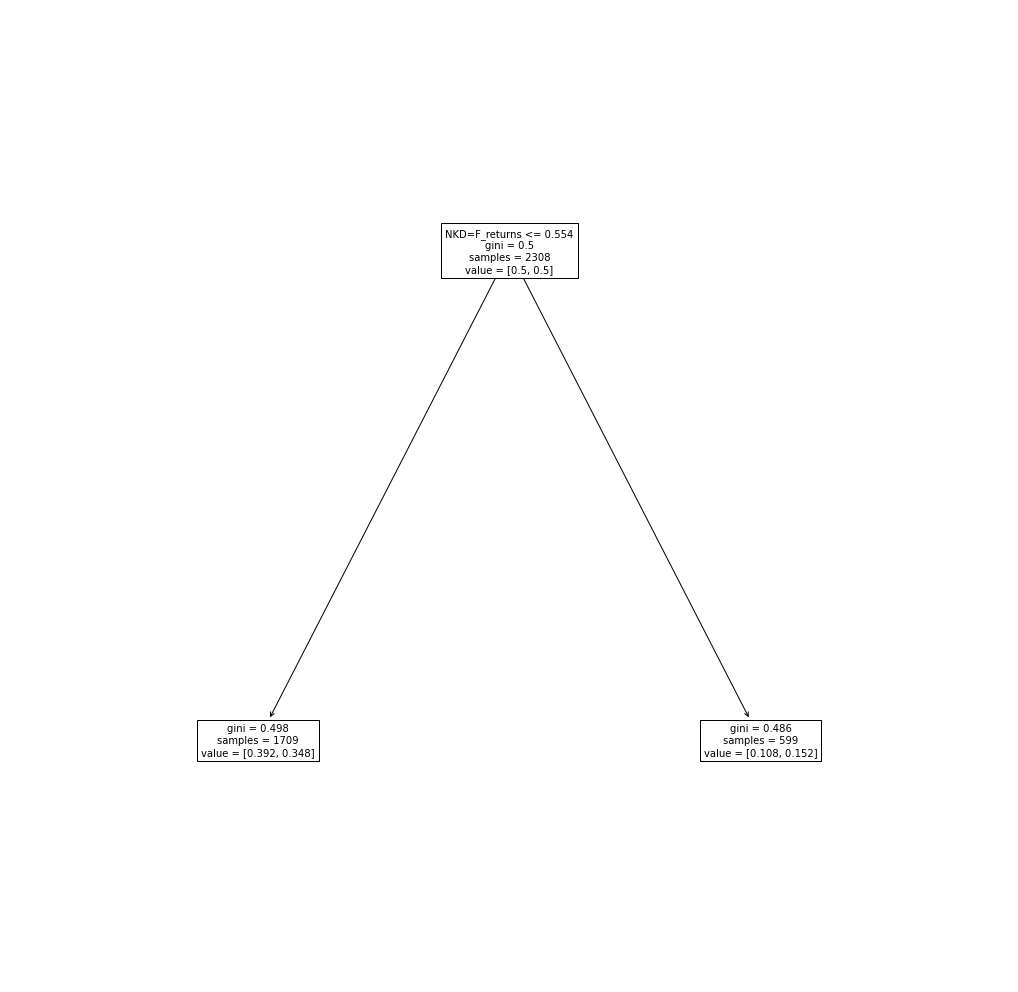

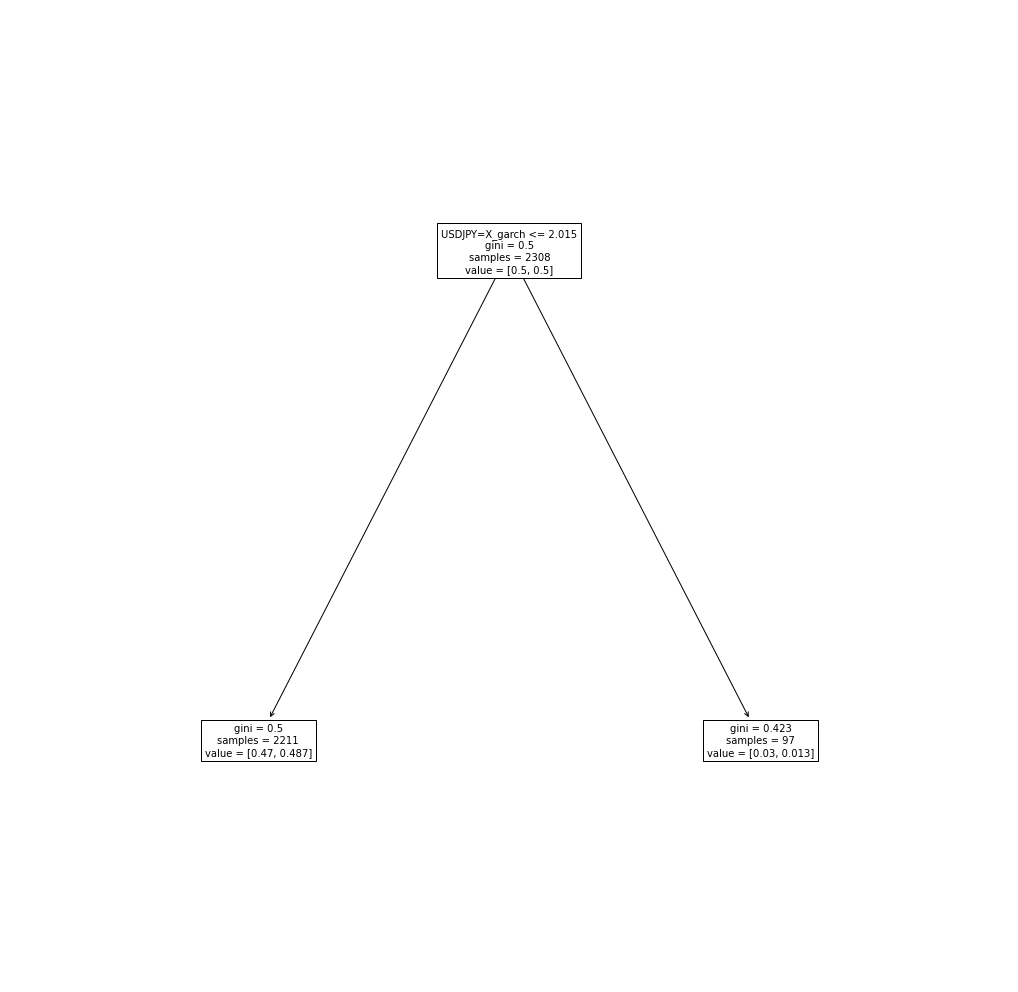

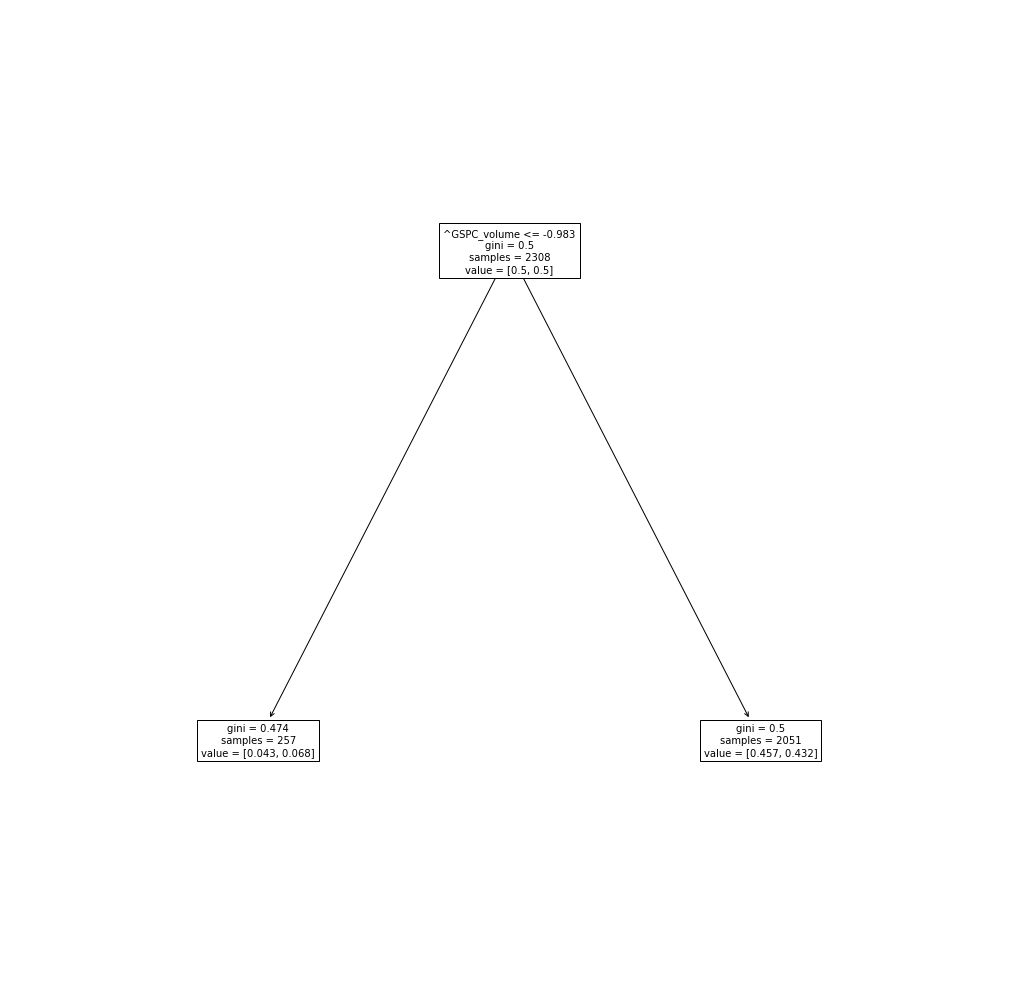

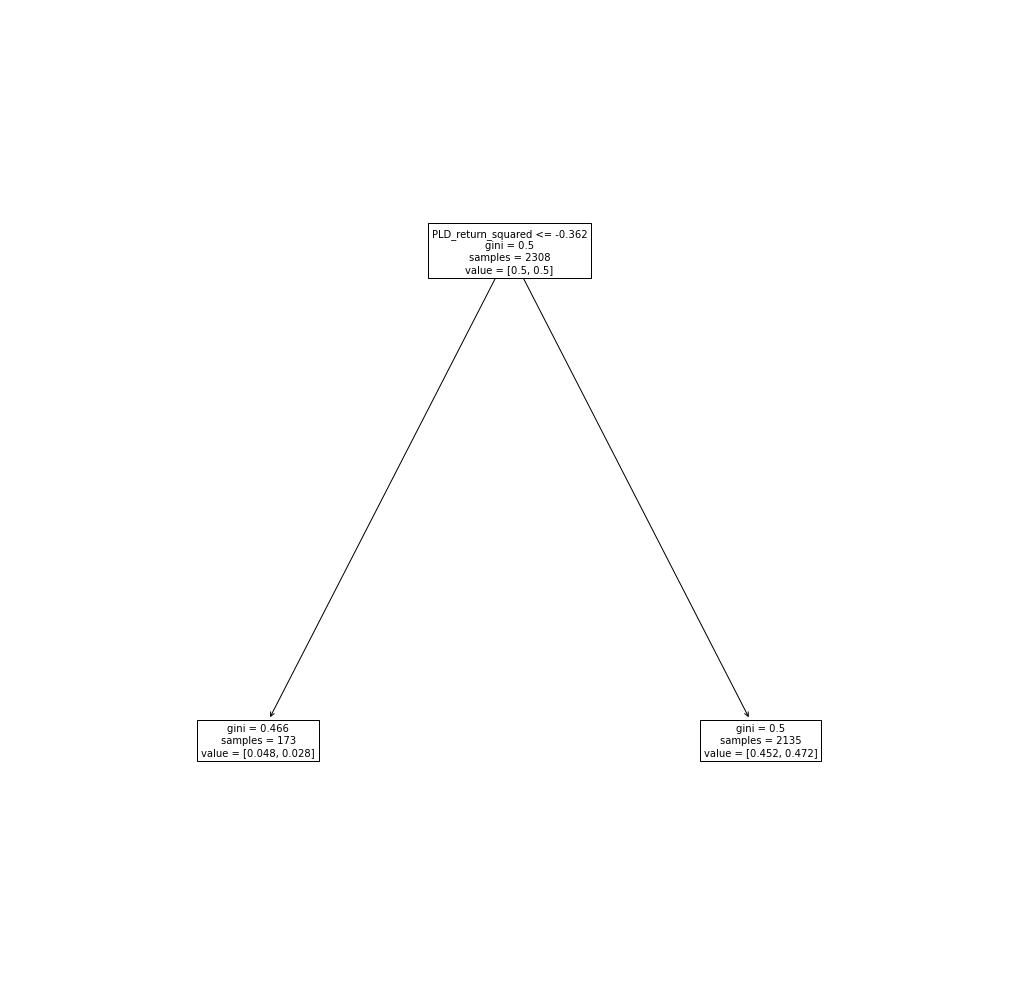

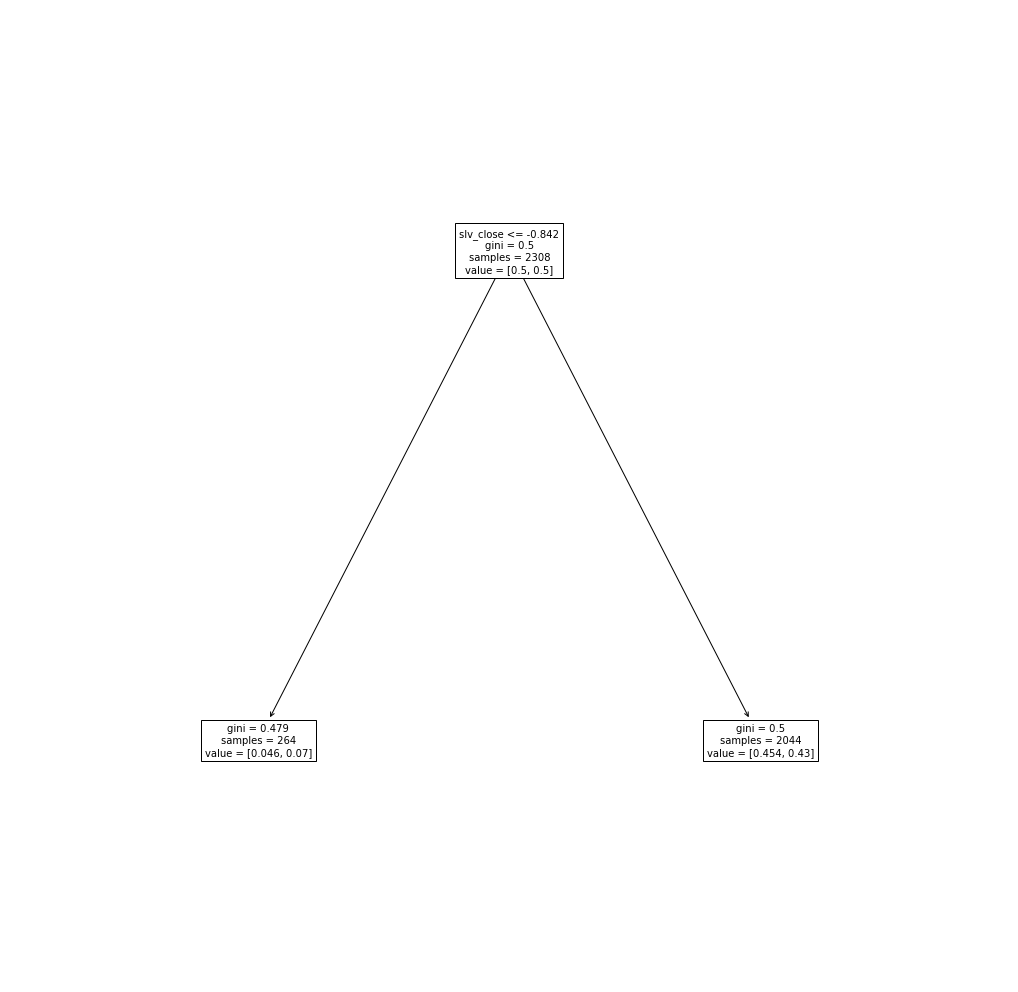

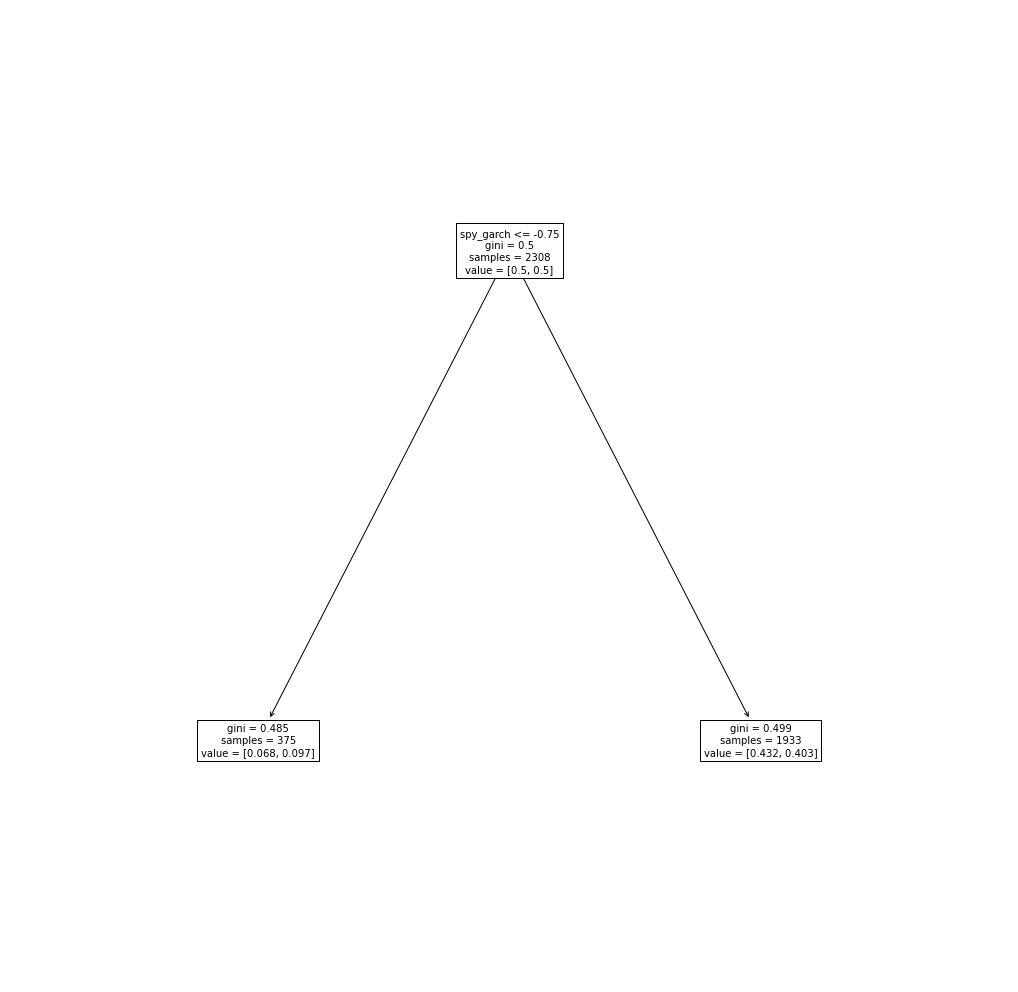

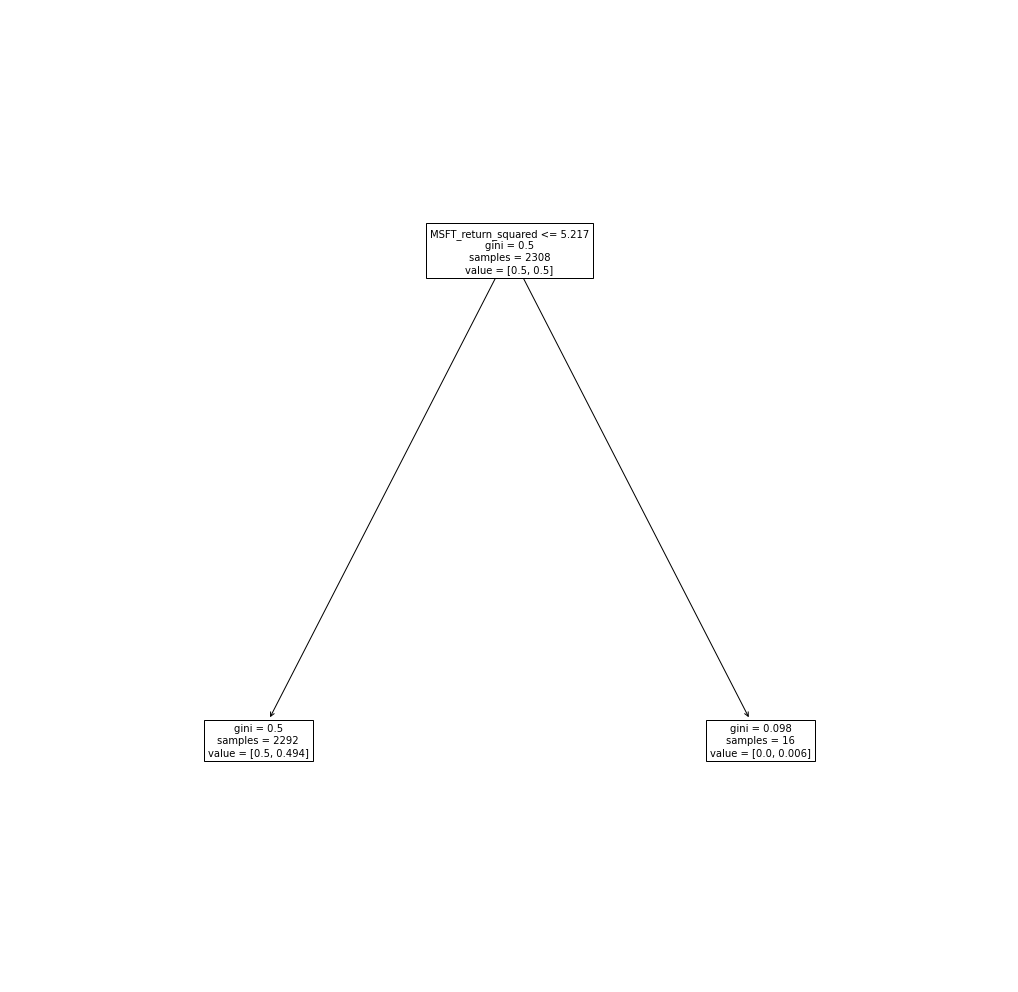

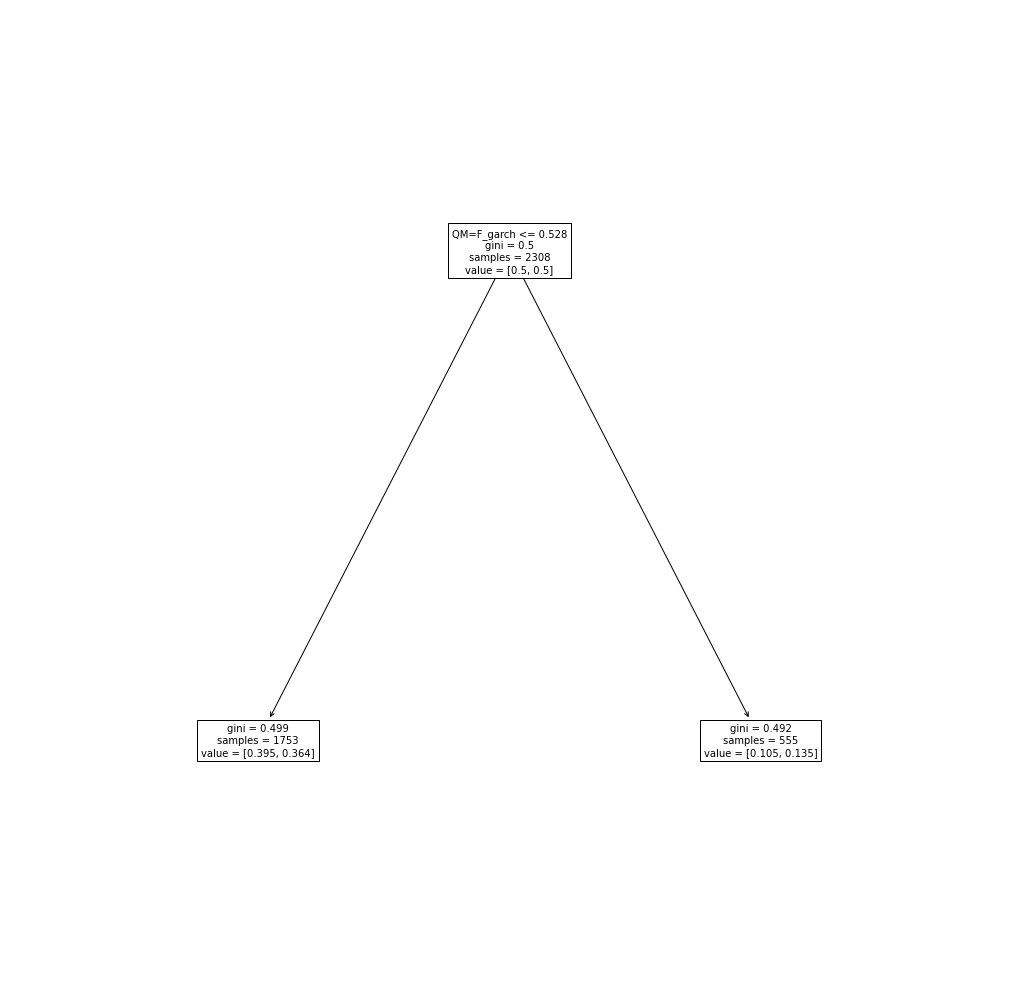

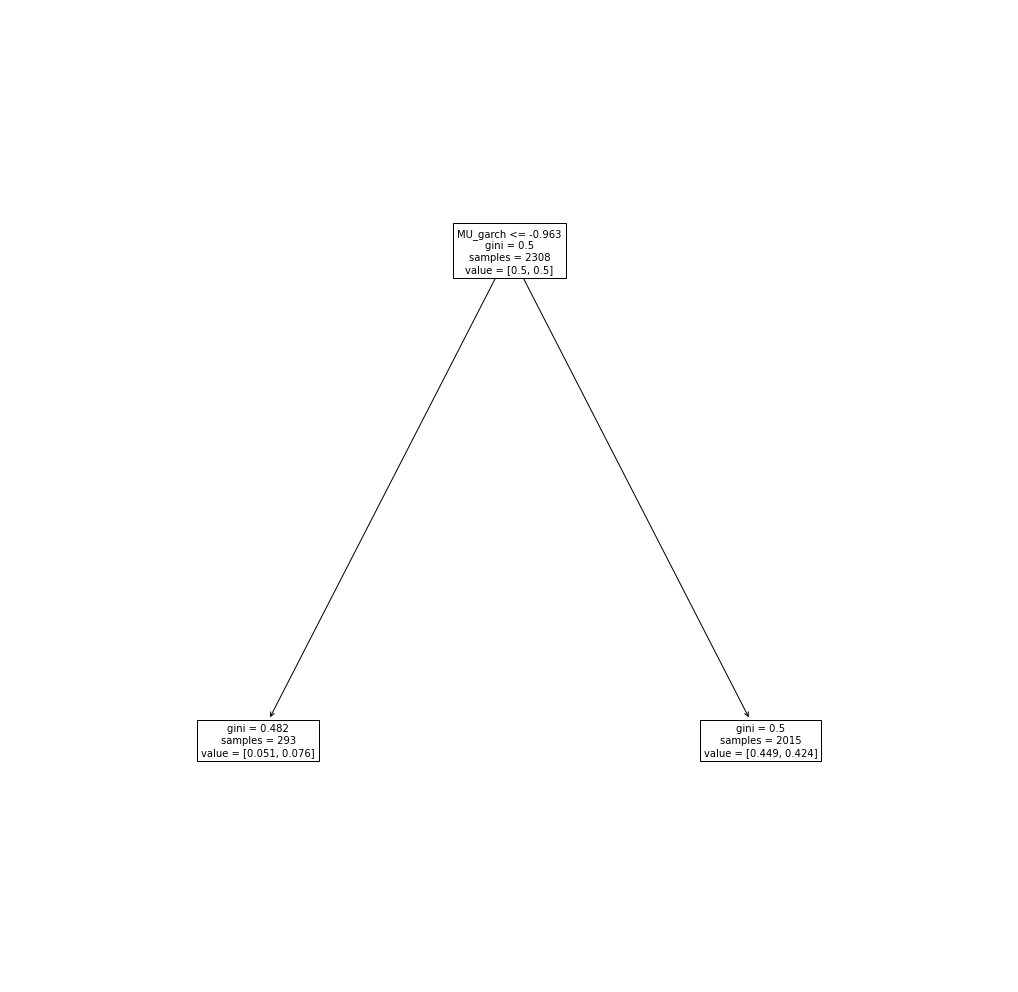

In [459]:
from sklearn import tree
#adaboost_model.estimators_
#tree.plot_tree(adaboost_model.estimators_[0],fontsize=10)

import matplotlib.pyplot as plt
# plot tree

for i in range(0,len(adaboost_model.estimators_)):
    plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
    tree.plot_tree(adaboost_model.estimators_[i],fontsize=10, feature_names=X.columns, proportion=False)
    plt.show()

# Profitability Analysis
The large size of VIX returns would make a huge compounding effect if it were possible to bet on it and track its performance,.
As can be seen below, the average size of daily returns are around 5%, with returns that can get as large as 115% in one day. The median is 

In this section we will compare the results of betting on the model applying an imaginary strategy of betting at the open of the day, and close the bet at the end of the day. We will assume that the approximately the open level will be very similar than the close level of the previous day.

In [460]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics=abs(100 * security_returns_df['VIXM']).describe()
display(vixm_return_statistics)

count    2818.000000
mean        1.387288
std         1.504899
min         0.000000
25%         0.431776
50%         0.987569
75%         1.851035
max        18.214719
Name: VIXM, dtype: float64

In [461]:
vixm_ret.loc['2011-02-21']
#y_train_df.index.min()
#y_train_df.index.max()

VIXM_ret    0.059293
Name: 2011-02-21 00:00:00, dtype: float64

### In-sample analysis: Return on $1 invested on training data window

In [462]:
# Results comnparison

# Profitability on the train window
fit_train= adaboost_model.predict(X_train_scaled)
fit_train_df= pd.DataFrame(fit_train, index=X_train.index)

fit_train_df.hvplot()

y_train_df=pd.DataFrame(y_train, index=X_train.index)
y_train_df

vixm_returns_train_df=vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
vixm_returns_train_df = vixm_returns_train_df.loc[y_train_df.index]


results_train_df=pd.concat([vixm_returns_train_df, y_train_df, fit_train_df], axis=1)

results_train_df.columns=['VIXM Return', 'Correct Signal', 'Fit Signal']

predicted_return=results_train_df['VIXM Return']*results_train_df['Fit Signal']
max_return=results_train_df['VIXM Return']*results_train_df['Correct Signal']


results_train_df=pd.concat([results_train_df, predicted_return, max_return], axis=1)
results_train_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Fit Return', 'Max Return']


return_of_one_dollar_in_train_window_df=(1+results_train_df[['VIXM Return','Fit Return']]).cumprod()
return_of_one_dollar_in_train_window_df.columns=['VROI', 'ROI Model (in sample)']

profitability_train_plot=return_of_one_dollar_in_train_window_df.hvplot(
                                             title="In-Sample Growth of $1 initial Investment in Daily Trade Strategy on VIX",
                                             ylabel="Dollars $" ,
                                             width=1000
 )

profitability_train_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [463]:
y_train_df.index

DatetimeIndex(['2011-02-21', '2011-02-23', '2011-02-24', '2011-02-25',
               '2011-02-28', '2011-03-01', '2011-03-02', '2011-03-03',
               '2011-03-04', '2011-03-07',
               ...
               '2019-10-08', '2019-10-09', '2019-10-10', '2019-10-11',
               '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17',
               '2019-10-18', '2019-10-21'],
              dtype='datetime64[ns]', name='Date', length=2163, freq=None)

### Out-of--sample analysis: Return on $1 invested on training data window

In [464]:
# Results comnparison

# Profitability on the test window

# Out-of-sample Predictions 
prediction_test= adaboost_model.predict(X_test_scaled)
prediction_test_df= pd.DataFrame(prediction_test, index=X_test.index)

# Out-of-sample signals (1s or 0s) based on actual returns of the VIX
y_test_df=pd.DataFrame(y_test, index=X_test.index)
y_test_df

# VIX returns in the test window
vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

# Combination of VIX Returns, signals and predictions
results_test_df=pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal']

# Predicted returns
predicted_return=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
max_return=results_test_df['VIXM Return']*results_test_df['Correct Signal']

# DataFrame with out-of-sample results for comparison
results_test_df=pd.concat([results_test_df, predicted_return, max_return], axis=1)
results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Predicted Return', "Max Return"]

return_of_one_dollar_in_test_window_df=(1+results_test_df[['VIXM Return', 'Predicted Return']]).cumprod()
return_of_one_dollar_in_test_window_df.columns=['VIXM Cummulative return', ' Model Cummulative Return (out of sample)']


#Plot with out of sample return on a 1 dollar investment for the VIX, and the daily bet strategy
profitability_test_plot=return_of_one_dollar_in_test_window_df.hvplot(
                         title='Out-Of-Sample Growth of $1 initial Investment in Daily Trade Strategy on VIXM',
                         ylabel= "Dollars $",
                         width=1000
                        )
profitability_test_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [468]:
# Results in prediction of daily returns
min_return=threshold
results_test_for_plot_df=results_test_df[abs(results_test_df['VIXM Return'])>min_return]*100

results_test_for_plot_df.hvplot(
                    y=['VIXM Return', 'Predicted Return'],
                    title= "Out-of-sample predictions of VIXM return",
                    width=1000,
                    ylabel='Daily Return (%)'
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [469]:
#Histogram of returns out of sample
results_test_for_plot_df.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIXM returns predictions"
)

:NdOverlay   [Element]
   :Histogram   [Predicted Return]   (Predicted Return_count)

### Analysis of good and bad predictions

In [470]:
# Analysis of the good and bad out-of-sample predictions
good_predictions=results_test_df[results_test_df['Correct Signal']==results_test_df['Predicted Signal']]

bad_predictions=results_test_df[results_test_df['Correct Signal']!=results_test_df['Predicted Signal']]


In [471]:
good=good_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns of Good Predictions"
)

bad=bad_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns on Bad Predictions"
)
good+bad

:Layout
   .NdOverlay.I  :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)
   .NdOverlay.II :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)

In [472]:
# Good prediction statistics
good_predictions[['VIXM Return', 'Predicted Return']].describe()

VIXM Return  Predicted Return
count   299.000000        299.000000
mean     -0.000792          0.007714
std       0.027761          0.021209
min      -0.106364         -0.022076
25%      -0.014056         -0.000000
50%      -0.001891         -0.000000
75%       0.008164          0.008164
max       0.182147          0.182147

In [473]:
# Bad prediction statistics
bad_predictions[['VIXM Return', 'Predicted Return']].describe()

VIXM Return  Predicted Return
count   222.000000        222.000000
mean      0.003170         -0.006431
std       0.025796          0.012357
min      -0.140413         -0.140413
25%      -0.009878         -0.009467
50%      -0.000504         -0.000329
75%       0.011951          0.000000
max       0.138069          0.000000

In [474]:
# Box Plot predictions for good and bad predictions
good_pred=good_predictions['Predicted Return']
bad_pred =bad_predictions['Predicted Return']

predictions_comparison_df=pd.concat([good_predictions['Predicted Return'],bad_predictions['Predicted Return']], axis=1, ignore_index=True )*100
predictions_comparison_df.hvplot(kind='box',
                                height=800,
                                ylabel='Return (%)',
                                #clabel=['Good Predictions', 'Bad Predictions'],
                                cmap=['blue','red'],
                                title="Out-of-sample Good and Bad Returns Resulting from Model Predictions Box Plots")





#df = pd.DataFrame(np.random.randn(20), columns=['Value'])
#df['Source'] = ['Preds'] *10 +['Real'] * 10
#df['Item'] = ['item1'] *5 + ['item2']*5 + ['item1'] *5 + ['item2']*5
#df.hvplot.box(y='Value', by=['Item', 'Source'])

:BoxWhisker   [Variable]   (value)

# OUTPUTS FOR TUNNING

In [475]:
def prepare_features(XY, pca_components):
    XY_modified = XY.shift().dropna()
    y = XY_modified["Signal"].shift(-1)
    X = XY_modified
    pca = PCA(n_components = pca_components)
    principal_components = pca.fit_transform(X)
    
    pca_column_list = []
    for i in range(1, pca_components+1):
        pca_column_list.append(f"pca{i}")

    principal_components_train_test_df = pd.DataFrame(data = principal_components, columns = pca_column_list, index = XY_modified.index)
    X_pca_lag1 = create_pca_lag1(principal_components_train_test_df)
    X_pca_lag2 = create_pca_lag2(principal_components_train_test_df)
    X_pca_lag3 = create_pca_lag3(principal_components_train_test_df)
    X_pca_lag4 = create_pca_lag4(principal_components_train_test_df)
    X_pca_lag5 = create_pca_lag5(principal_components_train_test_df)
        
    X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)
    X_pc = concatenate_pca_with_lags(principal_components_train_test_df, X_pc_lags)
    X, y = eliminate_nans_in_pca_data(X_pc, y)
    
    X_train, y_train, X_test, y_test = split_training_test_data(X, y)
    X_train_resampled, y_train_resampled = random_over_sample(X_train, y_train)
    X_train_scaled, X_test_scaled = standard_scale(X_train_resampled, X_test)
    #principal_components_train_test
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
    return X_train_scaled, X_test_scaled, y_train_resampled, y_test

In [312]:
if run_multiple_tuning_iterations == True: 
    for num_estimators in range (1,25, 1):
        for depth in range(1,4,1):
            for rate in range(1,25,2):
                base = DecisionTreeClassifier(max_depth=depth)
                adaboost_model=AdaBoostClassifier(base_estimator=base, 
                                      n_estimators=num_estimators, 
                                      learning_rate= rate/10 )

                # Fit the model 
                adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)
                pred_adaboost = adaboost_model.predict(X_test)
                # Use a classification report to evaluate the model using the predictions and testing data
                adaboost_report=classification_report(y_test, pred_adaboost)

                #if num_estimators % 10 == 0 and num_components == 88:
                #    print(f"components {num_components} esimators {num_estimators}")
                #    print(f"f1 score 0 {f1_score(y_test, pred_adaboost, pos_label=0)} f1 score 1 {f1_score(y_test, pred_adaboost, pos_label=1)}")
                #    print(f"accuracy {accuracy_score(y_test, pred_adaboost)}")
                #    print(adaboost_report)
                f1_score_1 = f1_score(y_test, pred_adaboost, pos_label=1)
                f1_score_0 = f1_score(y_test, pred_adaboost, pos_label=0)
                recall_score_1 = recall_score(y_test, pred_adaboost, pos_label=1)
                recall_score_0 = recall_score(y_test, pred_adaboost, pos_label=0)
                accuracy_score_model = accuracy_score(y_test, pred_adaboost)
                if  accuracy_score_model >= .54 and f1_score_1 >= .50 and f1_score_0 >= .50 and recall_score_1 >= .50 and recall_score_0 >= .50:
                    print(f"estimators {num_estimators}, max tree deph: {depth}")
                    # print(f"variance explained {sum(pca.explained_variance_ratio_)}")
                    # Print the classification report
                    print("         AdaBoost Classification Report")
                    print(adaboost_report)
                #print(f"Trying deph {depth}, n_estimators {num_estimators}, lewrning rate {rate/10}")

Trying deph 1, n_estimators 1, lewrning rate 0.1
Trying deph 1, n_estimators 1, lewrning rate 0.3
Trying deph 1, n_estimators 1, lewrning rate 0.5
Trying deph 1, n_estimators 1, lewrning rate 0.7
Trying deph 1, n_estimators 1, lewrning rate 0.9
Trying deph 1, n_estimators 1, lewrning rate 1.1
Trying deph 1, n_estimators 1, lewrning rate 1.3
Trying deph 1, n_estimators 1, lewrning rate 1.5
Trying deph 1, n_estimators 1, lewrning rate 1.7
Trying deph 1, n_estimators 1, lewrning rate 1.9
Trying deph 1, n_estimators 1, lewrning rate 2.1
Trying deph 1, n_estimators 1, lewrning rate 2.3
Trying deph 1, n_estimators 1, lewrning rate 2.5
Trying deph 1, n_estimators 1, lewrning rate 2.7
Trying deph 1, n_estimators 1, lewrning rate 2.9
Trying deph 2, n_estimators 1, lewrning rate 0.1
Trying deph 2, n_estimators 1, lewrning rate 0.3
Trying deph 2, n_estimators 1, lewrning rate 0.5
Trying deph 2, n_estimators 1, lewrning rate 0.7
Trying deph 2, n_estimators 1, lewrning rate 0.9
Trying deph 2, n_est

In [451]:
# Number of estimators? 
if run_multiple_tuning_iterations == True:
    for n in range (50,200, 10):
        # Instance AdaBoost
        # Initiate the model instance
        adaboost_model=AdaBoostClassifier(n_estimators=n)

        # Fit the model 
        adaboost_model =adaboost_model.fit(X_train_scaled, y_train)
        pred_adaboost=adaboost_model.predict(X_test_scaled)
        print (n)
        # Use a classification report to evaluate the model using the predictions and testing data
        adaboost_report=classification_report(y_test, pred_adaboost)

        # Print the classification report
        print("         AdaBoost Classification Report")
        print(adaboost_report)
#120 highest 1-recall
#150 good overall accuracy, but lower 1-recall


50
         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.61      0.57      0.59       569
         1.0       0.51      0.54      0.53       464

    accuracy                           0.56      1033
   macro avg       0.56      0.56      0.56      1033
weighted avg       0.56      0.56      0.56      1033

60
         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.60      0.55      0.58       569
         1.0       0.50      0.55      0.53       464

    accuracy                           0.55      1033
   macro avg       0.55      0.55      0.55      1033
weighted avg       0.56      0.55      0.55      1033

70
         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.61      0.51      0.55       569
         1.0       0.50      0.61      0.55       464

    accuracy                           0.55      1033

#### Future enhancements:

* Clear variables that are not important
* Try increasing the deph of the AdaBoost model
* Include more features
* X8: use a function to generate the rolling volatilities, and set the number on the column name